**Multimodal Speech Emotion Recognition**
====== 
*Notebook created in PyTorch by Alvaro García, Carla Campás, Héctor Colado and Jorge García under the supervision of Carlos Escolano for the Postgraduate in Artificial Intelligence with Deep Learning of the UPC (2022-2023)*

 


## **Motivation**
<p align="justify"> Speech Emotion Recognition is the task of recognizing the human emotion from speech irrespective of the semantic contents. This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch.

<p align="justify"> From a scientific point of view, Speech emotion recognition is a growing field with many potential opportunities in several areas such as improving human-computer interaction, enhancing mental health diagnosis or enhancing customer experience.
Additionally, it can be used to address societal issues such as  social inequality and communication barriers, making it a socially impactful field of study.

<p align="justify"> But for an effective emotion recognition, the analysis of only one channel is not enough accurated. So, the exploration and combination of several channels, like text, audio, video are mandatory to obtain valuable results.
<p align="justify"> Multimodal data analysis exploits information from multiple-parallel data channels for decision making. 







## **Goal**
<p align="justify"> In this work, we want to explore the multimodal data analysis from a scientific perspective. Concreteley, our main goals are:

<p align="justify"> Understanding State-of-the-Art of Multi-modal Research

*   Extensively research state-of-the art applications of multi-modal architectures
*   Find accessible data pertaining to emotion detection in a multi-modal scope


<p align="justify"> Implementing and evaluating fully-functional Deep Learning architecture able to classify emotions

*   Experiment with different DL architectures for emotion recognition
*   Learn how to integrate multimodal data
*   Learn and experiment with data augmentation (stretch goal)






<p align="justify"> Multimodal EmotionLines Dataset (MELD) has been created by enhancing and extending EmotionLines dataset with  audio and visual modalities along with text. 

<p align="justify"> The MELD Dataset, used in our project, has more than 1400 dialogues and 13000 utterances from Friends TV series. 

<p align="justify"> Multiple speakers participated in the dialogues. 
Each utterance in a dialogue has been labeled by any of these seven emotions -- Anger, Disgust, Sadness, Joy, Neutral, Surprise and Fear.

<p align="justify"> MELD also has sentiment (positive, negative and neutral) annotation for each utterance, but we have not concentrated on this analytics during  the current project.

<p align="justify"> A sample of a dialogue, is shown below: 

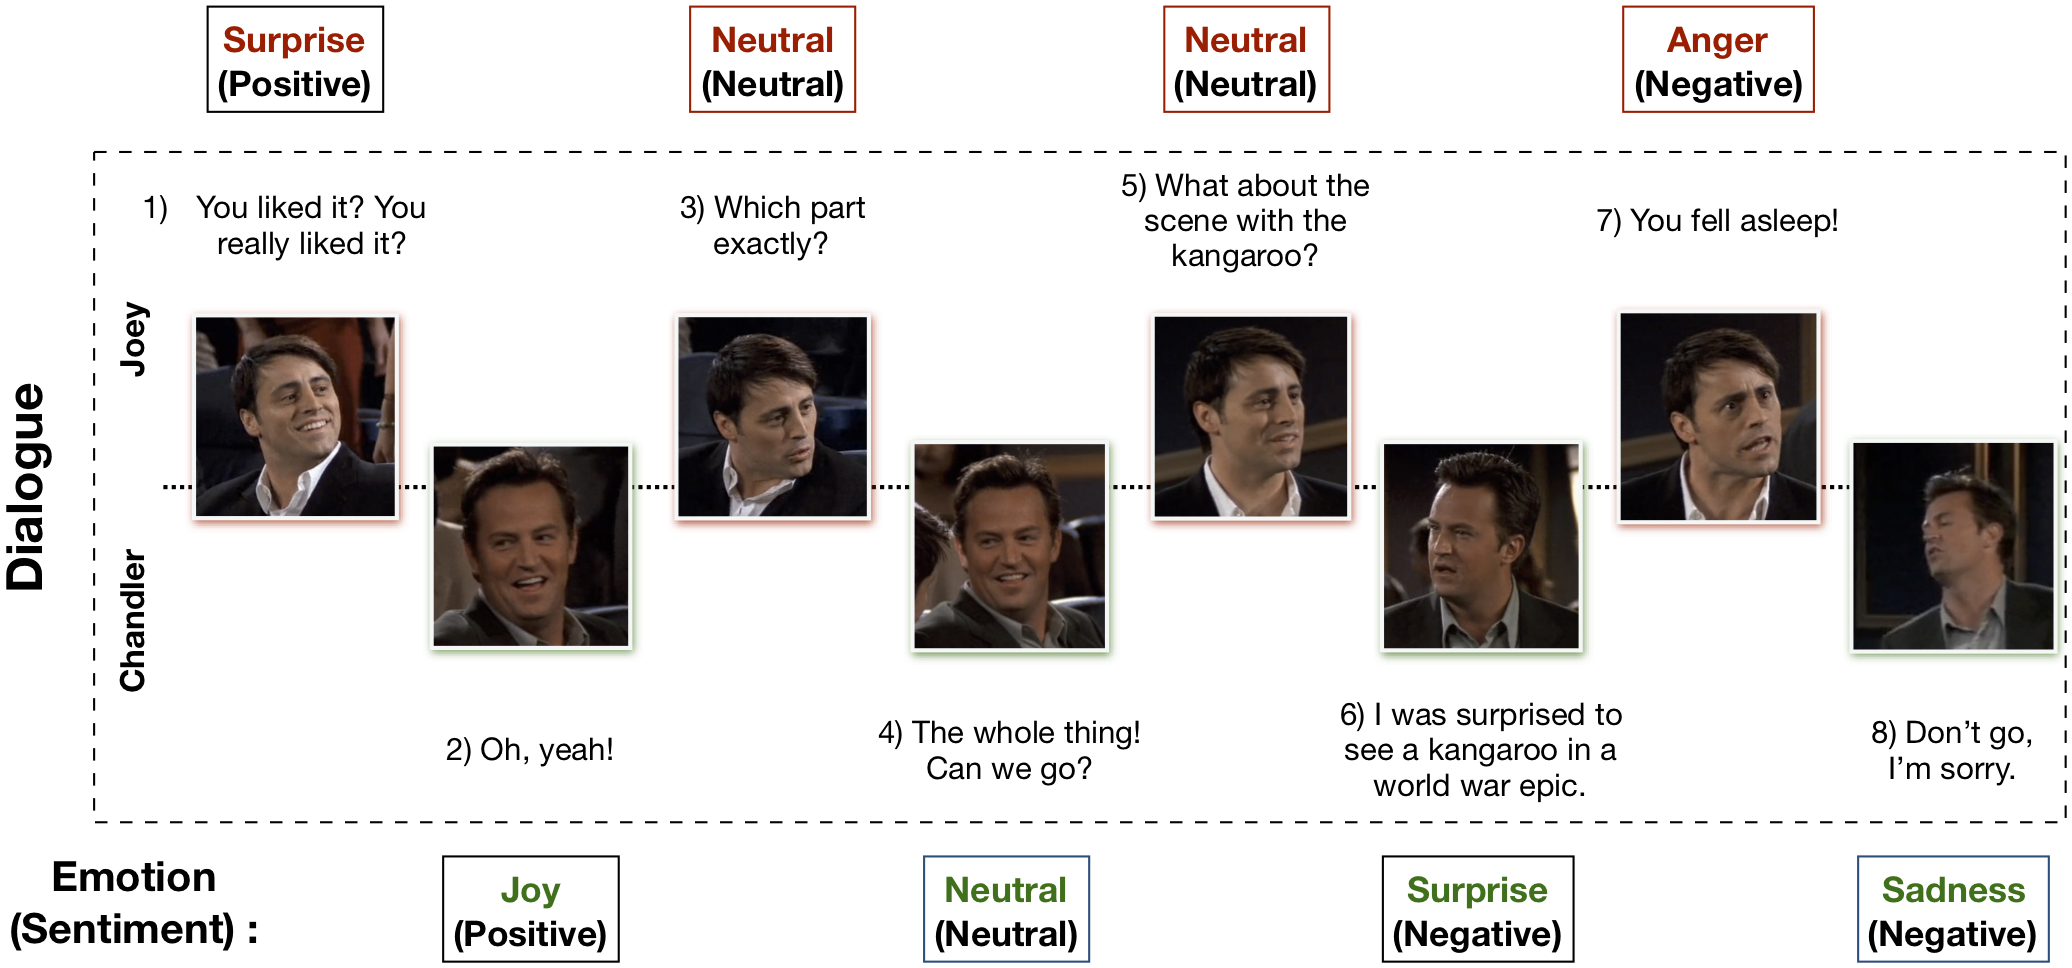

## **Infrastructure preparation**
<p align="justify"> First step for the project is the selection of the required libraries to support the management of audio and the pytorch basis functionality. Additionally, it is strongly recommended to set GPU as hardware accelerator in `Runtime > Change runtime type > Hardware Accelerator`

In [ ]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 7.1 MB/s eta 0:00:00


In [ ]:
pip install torchextractor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pickle
import random
import torch
import torchmetrics

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import math
import itertools
import copy
import seaborn as sn

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchextractor as tx

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, Sampler, BatchSampler, SequentialSampler

from torchmetrics.classification import BinaryF1Score, MulticlassF1Score, MultilabelF1Score

from torchtext import data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from sklearn.metrics import confusion_matrix


<p align="justify"> Set the seed for the CPU/GPU to generate random numbers so that the result is deterministic. 
Additionaly, try to get the most performant device for our analytics.

In [ ]:
seed = 123
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else torch.device('cpu'))
device

device(type='cuda')

### **Getting and understanding the data**

Get all the packages that contains the dataset used  for the analysis.  

In [ ]:
#!git clone https://github.com/declare-lab/MELD
!git clone https://github.com/UPC-AIDL-MER/meld_data

Cloning into 'meld_data'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 39 (delta 6), reused 37 (delta 4), pack-reused 0
Unpacking objects: 100% (39/39), 506.89 KiB | 7.04 MiB/s, done.
Filtering content: 100% (4/4), 838.72 MiB | 77.10 MiB/s, done.


**List of csv files**

*   /meld_data/data/MELD/train_sent_emo.csv - contains the utterances in the training set along with Sentiment and Emotion labels.
*   /meld_data/data/MELD/dev_sent_emo.csv - contains the utterances in the validation set along with Sentiment and Emotion labels.
*   /meld_data/data/MELD/test_sent_emo.csv - contains the utterances in the test set along with Sentiment and Emotion labels.




**Description of the .csv files**


<table>
  <tr> <th>Column Name</th> <th>Description</th> </tr>
  <tr> <td>Sr No.</td> <td>Serial numbers of the utterances mainly for referencing the utterances in case of different versions or multiple copies with different subsets</td> </tr>
  <tr> <td>Utterance</td> <td>Individual utterances from EmotionLines as a string.</td> </tr>
  <tr> <td>Speaker</td> <td>Name of the speaker associated with the utterance.</td> </tr>
  <tr><td>Emotion</td> <td>The emotion (neutral, joy, sadness, anger, surprise, fear, disgust) expressed by the speaker in the utterance.</td></tr>
  <tr><td>Sentiment</td> <td>The sentiment (positive, neutral, negative) expressed by the speaker in the utterance.</td></tr>
  <tr><td>Dialogue_ID</td> <td>The index of the dialogue starting from 0.</td></tr>
  <tr><td>Utterance_ID</td> <td>The index of the particular utterance in the dialogue starting from 0.</td></tr>
  <tr><td>Season</td> <td>The season no. of Friends TV Show to which a particular utterance belongs.</td></tr>
  <tr><td>Episode</td> <td>The episode no. of Friends TV Show in a particular season to which the utterance belongs.</td></tr>
  <tr><td>StartTime</td> <td>The starting time of the utterance in the given episode in the format 'hh:mm:ss,ms'.</td></tr>
  <tr><td>EndTime</td> <td>The ending time of the utterance in the given episode in the format 'hh:mm:ss,ms'.</td></tr>
</table>


**List of pickle files**

<p align="justify"> Python’s Pickle module is a popular format used to serialize and deserialize data types. This format is native to Python and restricted for this programming language. Pickle is the best choice when storing recursive structures since it only writes an object once, and is able to retain/retrieve the exact state of the serialized/deserealized objects.

**List of pickle files**

Generated by MELD research and used in this collab to be able to compare results:
*   /meld_data/MELD/pickle/audio_embeddings_feature_selection_emotion.pickle - contains audio embeddings already calculated for MELD features.

Generated by us but not used on this collab:
*   /meld_data/data/pickles/meldaudiodata_train.pickle - contains the MEL spectrograms of the training set along with the utterance identification.
*   /meld_data/data/pickles/meldaudiodata_dev.pickle - contains the MEL spectrograms of the validation set along with the utterance identification.
*   /meld_data/data/pickles/meldaudiodata_test.pickle - contains the MEL spectrograms of the test set along with the utterance identification.


**Description of the .pickle file**

Pickle files generated by MELD research: 
<table>
  <tr> <th>Column Name</th> <th>Description</th> </tr>
  <tr> <td>audio embedding</td> <td>Embedding respresentation of the audio spectrogram corresponding to the audio file</td></tr>
  <tr><td>utterance</td> <td>utterance identifiers</td></tr>
</table>

Pickle files generated by us: 
<table>
  <tr> <th>Column Name</th> <th>Description</th> </tr>
  <tr> <td>spectrogram</td> <td>Mel spectrogram corresponding to the audio file</td></tr>
  <tr><td>Filename</td> <td>Audio filename corresponding to a single utterance</td></tr>
</table>

## **Preparation of Datasets**

<p align="justify"> Dataset classes are a type of data structure used in machine learning and deep learning to manage and organize large sets of data for training and testing models.  There are several advantages to using dataset classes, including:

1.   Simplify data loading and preprocessing.
2.   Consistency, repeatability and realiability.
3.   Efficient memory management.
4.   Easy integration with popular frameworks.
5.   Flexibility through customization, such as handling different file formats, performing custom data augmentation, or handling missing data.

<p align="justify"> Overall, dataset classes can help streamline the data preparation process, improve the efficiency of training and testing models, and lead to more consistent and reliable results.

<p align="justify"> For our purposes, we have created a MELDDataset class that provides the required methods to manage the data in accordance with the specific channel to analize.

<p align="justify"> The MELDDataset is able to analyze the data from two different perspectives, depending of the source channel (channel_type):

1.   Textual analysis (through NLP techniques).
2.   Audio analysis (through SAP techniques).


<p align="justify"> Additionally, it is able to perform two different kind of analysis (type_mode):

1.   Emotion (objetive of this collab).
2.   Sentiment (reserved for future use).


<p align="justify"> Finally, it is specially customized to work with different dataset modes:

1.   Training.
2.   Validation.
3.   Test.



In [ ]:
class MELDDataset(object):
# Dataset class to support the MELD data. 
  #----------------------------------------------------------------------------------------
  # Method: MELDDataset.init
  # Constructor of the MELDDataset class 
  #----------------------------------------------------------------------------------------
  def __init__(self, annotations_folder, channel_type='text', type_mode='emotion', train_mode=0, vocab=None):
    #-----------------------------------------------------------------------
    # Validation of the arguments
    #-----------------------------------------------------------------------
    # Check if path exists.
    if not os.path.isdir(annotations_folder):
      # Raise error if path is invalid.
      raise ValueError('Invalid `path` variable! Needs to be a directory')

    # Check if training mode is a valid value.
    try:
        assert(train_mode <=2)
    except AssertionError as e:
        print("Set train_mode as '0': Train  or '1': Validation or '2': Test ")
        exit()

    # Check if channel type is a valid value.
    try:
        assert(channel_type in ['audio', 'text'])
    except AssertionError as e:
        print("Set channel_type as 'audio'  or 'text' ")
        exit()

    # Ensuruing in case of text analysis that the train vocabulary is used for validation and test datasets  
    if ((channel_type == 'text') and (train_mode != 0)  and (vocab is None)): 
      raise ValueError('For Validation and Test of text channel, the vocabulary calculated during training mode must be provided')


    #-----------------------------------------------------------------------
    # Initialization of member variables of the Dataset class
    #-----------------------------------------------------------------------
    # Prepare for future extensions
    self.channel_type = channel_type

    # Fixed dictionary for emotions
    self.emo_dict    = {'neutral': 0, 'surprise': 1, 'fear': 2, 'sadness': 3, 'joy': 4, 'disgust': 5, 'anger': 6}
    self.emo_counter = {'neutral': 0, 'surprise': 0, 'fear': 0, 'sadness': 0, 'joy': 0, 'disgust': 0, 'anger': 0}

    # Extract data from csv file depending of the training mode and type
    self.mode = type_mode
    self.train_mode = train_mode
    self.annotation_file = "{}/data/MELD/{}_sent_emo.csv".format(annotations_folder, ('train','dev','test')[train_mode])
    dataframe = pd.read_csv(self.annotation_file)

    self.emo_labels, self.emo_counter = self.processLabels(dataframe.iloc[:,3])
    self.len = len(dataframe)

    self.utterance_ids = self.computeUtteranceIDs(dataframe)
    
    if (channel_type =='audio'):
      #---------------------------------------------------------------------------
      # Specific actions to prepare the audio analysis
      #---------------------------------------------------------------------------
      # Previous to the audio analysis, audio files have been preprocessed as 
      # MEL-spectrogramms. The spectrogramms have been included in a dictionary and 
      # stored in a pickle file.  
      self.pickle_file = "{}/MELD/pickle/audio_embeddings_feature_selection_emotion.pickle".format(annotations_folder)
  
      self.spectrograms = self.loadAudioFiles(self.pickle_file)
      #---------------------------------------------------------------------------

    
    if (channel_type =='text'):

      #---------------------------------------------------------------------------
      # Specific actions to prepare the script analysis
      #---------------------------------------------------------------------------
      # For this part, a vocabulary for the dataset (only train) is created at first.
      # Based on it, the utterances are tokenized and indexed for further use.

      if (vocab is None):
        self.vocab = self.computeVocabulary(dataframe.iloc[:,1])
      else:
        self.vocab = vocab

      self.utterance_tokens, self.utterance_indices = self.textPreprocessor(dataframe.iloc[:,1], self.vocab)
      #---------------------------------------------------------------------------
    return


  #----------------------------------------------------------------------------------------
  # Method: MELDDataset.len
  # Returns the number of elements of the dataset
  #----------------------------------------------------------------------------------------
  def __len__(self):
    return self.len


  #----------------------------------------------------------------------------------------
  #Method: MELDDataset.getitem
  # Returns the element of the dataset specified by the index
  # For textual analisys, the retrieved data is: 
  #     - utterance embedding,  labeled emotion, utterance id  
  # For audio analisys, the retrieved data is: 
  #     - utterance spectrogram, labeled emotion, utterance id  
  #----------------------------------------------------------------------------------------
  def __getitem__(self, idx):
    if(self.channel_type =='text'):
      return self.utterance_indices[idx], \
             self.emo_labels[idx], \
             self.utterance_ids[idx]

    if(self.channel_type =='audio'):
      return self.spectrograms[idx], \
             self.emo_labels[idx], \
             self.utterance_ids[idx]


  #----------------------------------------------------------------------------------------
  # Method: MELDDataset.label2emotion 
  # Returns the emotion value associated to the specified emotion label (default: 0) 
  #----------------------------------------------------------------------------------------
  def label2emotion(self, key):
    return self.emo_dict.get(key, 0) #if key does not exist, then returns default value = 0 


  #----------------------------------------------------------------------------------------
  #Method: MELDDataset.label2emotion 
  # Returns the emotion label associated to the specified emotion value (default: neutral) 
  #----------------------------------------------------------------------------------------
  def emotion2label(self, value):
    k = [k for k, v in self.emo_dict.items() if v == value]
    if k:
      return k[0]
    return 'neutral'


  #----------------------------------------------------------------------------------------
  #Method: MELDDataset.getEmotionCounting 
  # Returns the amount of elements in the dataset of a specified emotion   
  #----------------------------------------------------------------------------------------
  def getEmotionCounting(self, label):
    if (label in self.emo_counter):
      emo_count = self.emo_counter[label]
    else:
      emo_count = 0   
    return emo_count


  #----------------------------------------------------------------------------------------
  #Method: MELDDataset.getEmotionDict 
  # Returns the emotion dictionary   
  #----------------------------------------------------------------------------------------
  def getEmotionDict(self, order=False):
    if (order):
      return {k: v for k, v in sorted(self.emo_dict.items(), key=lambda x: x[1])}
    else:
      return self.emo_dict


  #----------------------------------------------------------------------------------------
  #Method: MELDDataset.getEmotionCountingList: 
  # Returns the amount of elements in the dataset of every specific emotion   
  #----------------------------------------------------------------------------------------
  def getEmotionCountingList(self, order=False):
    if (order):
      return {k: v for k, v in sorted(self.emo_counter.items(), key=lambda x: x[0])}
    else:
      return self.emo_counter


  #----------------------------------------------------------------------------------------
  # Method: MELDDataset.processLabels
  # Identifies and calculates the amount of emotion of the dataset 
  #----------------------------------------------------------------------------------------
  def processLabels(self, label_list):
    emotion_list = []
    emotion_counter = dict()
    for label in label_list:
      emotion_list.append(self.label2emotion(label))
      if (label in emotion_counter):
        emotion_counter[label] += 1
      else:
        emotion_counter[label] = 1

    return emotion_list, emotion_counter


  #----------------------------------------------------------------------------------------
  # Method: MELDDataset.computeUtteranceIDs
  # Generates a list of unique ids for the utterances used for temporal reordering of them
  #----------------------------------------------------------------------------------------
  def computeUtteranceIDs(self, dataframe):
    """
        Ouput  :  ids: [(Dialogue_id, Utterance_id)]
    """
    dialogue_ids = dataframe.iloc[:,5]
    utterance_ids = dataframe.iloc[:,6]
    ids = list(zip(dialogue_ids,utterance_ids))
    
    return ids


  #----------------------------------------------------------------------------------------
  # Method: MELDDataset.getUtteranceIDs
  # Returns the list of unique utterence ids
  #----------------------------------------------------------------------------------------
  def getUtteranceIDs(self):
    return  self.utterance_ids


  #----------------------------------------------------------------------------------------
  ##  TEXT RELATED METHODS    -------------------------------------------------------------
  #----------------------------------------------------------------------------------------

  #----------------------------------------------------------------------------------------
  # Method: MELDDataset.getVocabulary 
  # Returns the computed vocabulary
  #----------------------------------------------------------------------------------------
  def getVocabulary(self):
    return self.vocab


  #----------------------------------------------------------------------------------------
  # Method: MELDDataset.getVocabularySize 
  # Returns the size of the computed vocabulary
  #----------------------------------------------------------------------------------------
  def getVocabularySize(self):
    return len(self.vocab)


  #----------------------------------------------------------------------------------------
  # Method: MELDDataset.getPaddingValue 
  # Returns the token used for padding
  #----------------------------------------------------------------------------------------
  def getPaddingValue(self):
    return self.vocab["<pad>"]


  #----------------------------------------------------------------------------------------
  # Method: MELDDataset.text_preprocessor 
  # Calculates a list of tokenized sentences (one tokenized list for every sentence) and
  # the corresponding related list of indices 
  #----------------------------------------------------------------------------------------
  def textPreprocessor(self, textset, vocab):
    """
        Input  :  textset - List of sentences
                  vocab   - Vocabulary used to tokenize the list of sentences
        Purpose:  Calculates a list of tokenized sentences (one tokenized list for every sentence) 
                  and the corresponding related list of indices 
        Output :  tokenized_sent_list, indices_padded_sent_list  
    """
    tokenizer = get_tokenizer('basic_english')
   
    tokenized_sent_list = []
    indices_sent_list = []

    for sentence in textset:
      tokenized_sentence = tokenizer(sentence)
      indices_sentence = vocab.lookup_indices(tokenized_sentence)
      tokenized_sent_list.append(tokenized_sentence)
      indices_sent_list.append(indices_sentence)

    return  tokenized_sent_list, indices_sent_list 


  #----------------------------------------------------------------------------------------
  # Method: MELDDataset.computeVocabulary
  # Generates a vocabulary based on the provided dataset  
  #----------------------------------------------------------------------------------------
  def computeVocabulary(self, textset):
    """
        Input  : list of sentences
        Purpose: preprocess text (tokenize, removing stopwords, and stemming)
        Output : Vocabulary
    """

    tokenizer = get_tokenizer('basic_english')

    #TODO: PENDING TO LEMM/STEM + STOPWORDS
    def yield_tokens(data_iter):
      for text in data_iter:
        yield tokenizer(text)

    vocab = build_vocab_from_iterator(yield_tokens(textset), specials=["<pad>", "<unk>"])
    vocab.set_default_index(vocab['<unk>']) #Allows to get an index for unknown words in val/test
    return vocab



  #----------------------------------------------------------------------------------------
  ##  AUDIO RELATED METHODS   -------------------------------------------------------------
  #----------------------------------------------------------------------------------------

  #----------------------------------------------------------------------------------------
  # Method: MELDDataset.loadAudioFiles
  # Get the embeddings from the pickle file related to the spectrograms of the audio files 
  #----------------------------------------------------------------------------------------
  def loadAudioFiles(self, pickle_filename):
    """
        Input  : Name of the pickle file containing the audio embedding 
        Purpose: Loads pickle file to get the embeddings corresponding to the audio spectrograms 
        Output : embedding tensor list + ids  
    """
    file = open(pickle_filename, 'rb')
    train_audio_emb, val_audio_emb, test_audio_emb = pickle.load(file)
    file.close()

    if (self.train_mode == 0): #Training mode
      audio_embedding = list(train_audio_emb.values())

    if (self.train_mode == 1): #Validation mode
      audio_embedding = list(val_audio_emb.values())

    if (self.train_mode == 2): #Test mode
      audio_embedding = list(test_audio_emb.values())
    
    return audio_embedding



## **Preparation of Dataloader**

<p align="justify"> Working with a big dataset it becomes quite difficult to load the entire data into the memory at once. As such the only way forward is to load data into memory in batches for processing, an extra code to do this is needed: the Dataloader.

<p align="justify"> Creating a Dataset and managing it with Dataloader keeps the data manageable and helps to simplify the machine learning pipeline. A Dataset stores all our data, and a Dataloader can be used to iterate through the data, manage batches, transform the data, and much more.

<p align="justify"> For our project, the standard Pytorch Dataloader class have been used to manage our MELDDataset, but enhancing the load mechanism with some extra extensions.

<p align="justify"> First of all, because of the need to work with batches formed by elements of the same size, we have created a collate function. This kind of fucntion, provided to the Dtaloader as a parameter, allows us to provide additional function for processing any individual sample of the batch  before it is output.


<p align="justify"> Our MELDCollator class is responsible to align the sizes of all the elements of a batch by adding a padding value. So we have added the "<pad>" token during text analysis and the tensor [-100] (as silence) during the audio analysis. 

In [ ]:
class MELDCollator(object):
  """ This class iss used to collate and preprocess batches of variable-length sequences in the MELD dataset.
  """
  def __init__(self, padding_value):
    self.padding_value = padding_value
  
  def __call__(self, batch):
    values_list, label_list, ids_list = [], [], []
    for (_values, _label, _ids) in batch:
      label_list.append(torch.tensor(_label))
      values_list.append(torch.tensor(_values))
      ids_list.append(_ids)

    values_padded_list= pad_sequence(values_list,batch_first=True, padding_value=self.padding_value)
    return values_padded_list, torch.tensor(label_list), torch.Tensor(list(ids_list))


<p align="justify"> Additionally, to reduce the insertion of padding in our Datasets, that can affect negatively the learning process, we have created our own Batch Sampler.

<p align="justify"> The purpose of a data sampler is to determine how batches of data is formed from the given pool of data with given batch size. It also responsible for determining the order of the dataset which is fed into the model for learning.

<p align="justify"> For our data loader we wanted to achive the following steps:

- Sort the samples in the pool by the size of the token list. 
- Get multiple "pools", each of them with a size of batch_size
- Shuffle the pools randomly for the Data Loader  

<p align="justify"> Since we sort the samples in the pool, the texts with similar length will be grouped together. So, when we apply the collate function the required padding will be minimized.


In [ ]:
class ShuffleBatchSampler(BatchSampler):
    """Wraps another sampler to yield a mini-batch of indices.
       The `ShuffleBatchSampler` adds `shuffle` on top of `torch.utils.data.sampler.BatchSampler`.

    Args:
        sampler (Sampler): Base sampler.
        batch_size (int): Size of mini-batch.
        drop_last (bool): If ``True``, the sampler will drop the last batch if its size would be
            less than ``batch_size``.
        shuffle (bool, optional): If ``True``, the sampler will shuffle the batches.

    Example:
        >>> list(ShuffleBatchSampler(range(10), batch_size=3, drop_last=False))
        [[3, 4, 5], [9], [0, 1, 2], [6, 7, 8]]
        >>> list(ShuffleBatchSampler(range(10), batch_size=3, drop_last=True))
        [[3, 4, 5], [0, 1, 2], [6, 7, 8]]
    """
    def __init__(self, sampler, batch_size, drop_last,  shuffle=True):
        self.shuffle = shuffle
        super().__init__(sampler, batch_size, drop_last)

    def __iter__(self):
        batches = list(super().__iter__())
        if self.shuffle:
            random.shuffle(batches)

        return iter(batches)

In [ ]:
class BySequenceLengthSampler(Sampler):
  """ The purpose of this sampler is to iterate over a given dataset and 
      return batches of data samples based on their sequence length.

      Args:
        data_source     : Data source to sample.
        batch_size (int): Size of mini-batch.
        drop_last (bool): If ``True``, the sampler will drop the last batch if its size would be
            less than ``batch_size``.
        shuffle (bool, optional): If ``True``, the sampler will shuffle the batches.
  """

  def __init__(self, data_source, batch_size=64, drop_last=True, shuffle=True):
    self.shuffle = shuffle
    self.data_source = data_source
    self.drop_last = drop_last
    self.batch_size = batch_size

  def __iter__(self):
    indices =  [(idx, len(sentence[0])) for idx, sentence in enumerate(self.data_source)]
    indices.sort(key=lambda x: x[1])
    pooled_indices = [x[0] for x in indices]
    batch_sampler = ShuffleBatchSampler(pooled_indices, batch_size=self.batch_size, drop_last=self.drop_last, shuffle=self.shuffle)
    return batch_sampler.__iter__()

## **Creating the models**

### **1) Simple MLP Classifier model**

In [ ]:
class MELDTextClassifierMLP(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_size=128, n_emotions=7):
    super().__init__()
    self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
    
    self.mlp = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(embedding_dim, hidden_size),
                nn.LeakyReLU()
                )
    
    self.classifier = nn.Linear(hidden_size, n_emotions)
                
  def forward(self, x):
    x = self.embeddings(x)      #Output shape : (B, nº tokens/utterance, embedding_dim)
    x = torch.mean(x,1)         #Output shape : (B, embedding_dim)
    out = self.mlp(x)           #Output shape : (B, hidden_size)
    y = self.classifier(out)
    return y, out


### **2) Simple Text LSTM Classifier**

Basically this is an emotion classifier where the embeddings associated to every token are trained too


In [ ]:
class MELDTextClassifierLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_emotions=7) -> None:
      super().__init__()
      self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0) 
      
      self.LSTM = nn.LSTM(embedding_dim, embedding_dim, num_layers=2, bidirectional=True, batch_first=True, dropout=0.3) 
            
      self.classifier = nn.Linear(2*embedding_dim, n_emotions)

      self.dropout = nn.Dropout(0.5)
      

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      # x has to contain the indices associated with the tokens in the utterances of the batch
      # size(x) = (B, nº tokens/utterance) 

      x = self.embeddings(x)          #Output shape   : (B, nº tokens/utterance, embedding_dim)
      x = self.dropout(x)
      x, state = self.LSTM(x)         #Output shape x : (B, nº tokens/utterance, 2*embedding_dim)    
      out = torch.mean(x,1)           #Output shape   : (B, 2*embedding_dim)
      y = self.classifier(out)                       
      return y, out

### **3) Simple Audio LSTM Classifier**

In [ ]:
class MELDAudioClassifierLSTM(nn.Module):
    def __init__(self, embedding_dim, num_layers, n_emotions=7) -> None:
      super().__init__()

      self.dropout = nn.Dropout(0.5)

      self.LSTM = nn.LSTM(embedding_dim, 300, num_layers=num_layers, bidirectional=True, batch_first=True, dropout=0.4) 
     
      self.classifier = nn.Linear(2*300, n_emotions)
      

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      #x = self.dropout(x)
      out, state = self.LSTM(x) 
      y = self.classifier(out)
      return y, out

### **4) Simple Transformer Encoder**

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [batch size, sequence_length, embed dim]
            output: [batch size, sequence_length, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """
        
        positional_encoding =  self.pe[:x.size(1), :].unsqueeze(0) #He añadido aquí. Checkear Language_Model lab
        x = positional_encoding + x
        return self.dropout(x)

In [ ]:
class MELDTextClassifierTransformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, heads, num_encoders) -> None:
      super().__init__()

      self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx = 0) 
      self.pos_encoder = PositionalEncoding(d_model=embedding_dim)

      self.trans_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=heads, dim_feedforward=embedding_dim*4, batch_first=True, dropout=0.1)   
      self.trans_encoder = nn.TransformerEncoder(encoder_layer=self.trans_encoder_layer, num_layers=num_encoders)

      self.classifier = nn.Linear(embedding_dim, 7)
      self.dropout = nn.Dropout(0.5)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      # x has to contain the indices associated with the tokens in the utterances of the batch
      # size(x) = (B, nº tokens/utterance) 

      x = self.emb(x)  #Output shape : (B, nº tokens/utterance, embedding_dim)
      x = self.dropout(x)

      x = self.pos_encoder(x)
      x = self.trans_encoder(x) #Output shape x : (B, nº tokens/utterance, embedding_dim)  

      out = torch.mean(x,1) #Output shape : (B, embedding_dim)
      
      y = self.classifier(out)
      return y, out

## **Running the models**

### **Some utilities functions**

In [ ]:
def SearchForDiscrepancies(text_dataset, audio_dataset):
  # Calculates the discrepancies between the elements of two instances of MELD dataset 
  # Args:  text_dataset:  text dataset
  #        audio_dataset: audio dataset
  # Returns: List of ids for them it exist a text but not an audio
  #          List of ids for them it exist an audio but not a text

  list_ids = text_dataset.getUtteranceIDs().copy()
  list_audios= audio_dataset.getUtteranceIDs().copy()
  list_audios.sort()
  list_ids.sort()

  final_list_ids = []
  for key_pair in list_ids:
    if key_pair in list_audios:
      list_audios.remove(key_pair)
    else:
      final_list_ids.append(key_pair)

  return final_list_ids, list_audios


In [ ]:
def ShowEmotionHistogram(emotion_counts, title, X_axisName, Y_axisName):
  # Prints an histogram for the provided count list of emotions   
  # Args:  emotion_counts: dictionary counter of emotions  
  #        title: to show for the  histogram
  #        X_axisName: text to show for the X Axis
  #        Y_axisName: text to show for the Y Axis

  emotions = list(emotion_counts.keys())
  counts = list(emotion_counts.values())

  fig, ax = plt.subplots(figsize=(10, 6))
  ax.bar(emotions, counts, color=['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet'], edgecolor='black')
  ax.set_title(title, fontsize=18, fontweight='bold')
  ax.set_xlabel(X_axisName, fontsize=14)
  ax.set_ylabel(Y_axisName, fontsize=14)
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)

  # Add value labels above each bar
  for i, v in enumerate(counts):
      ax.text(i, v+5, str(v), horizontalalignment='center', fontsize=12)

  plt.show()

In [ ]:
from prettytable import PrettyTable
       
def ShowEmotionTable(emotion_list, train_counts, dev_counts, test_counts, total_counts):
  # Prints a table for the provided list of emotions and datasets modalities   
  # Args:  emotion_list: dictionary of emotions  
  #        train_counts: dictionary counter of emotions for the training data set  
  #        dev_counts: dictionary counter of emotions for the validation data set  
  #        test_counts: dictionary counter of emotions for the test data set  
  #        total_counts: dictionary counter of emotions for the whole set of data sets  

  table = PrettyTable()
  table.field_names = ["Emotion", "Train", "Validation", "Test", "Total"]
  for Emotion, Value in emotion_list.items():
    table.add_row( [Emotion, train_counts[Emotion], dev_counts[Emotion], test_counts[Emotion], total_counts[Emotion]])  

  table.add_row(["---", "---", "---", "---", "---"])  
  table.add_row(["TOTAL", sum(train_counts.values()), sum(dev_counts.values()), sum(test_counts.values()), sum(total_counts.values())])  
  print(table)

In [ ]:
def Show2Trends2D(X_trend1, Y_trend1, Y_trend1Name, X_trend2, Y_trend2, Y_trend2Name, title, X_Name, Y_Name, trendFilename):
  # Plots 2 trends in a common 2D Axis
  # Args:  X_trend1: X-Values of the first trend   
  #        Y_trend1: Y-Values of the first trend  
  #        Y_trend1Name: Name of the first trend  
  #        X_trend2: X-Values of the second trend   
  #        Y_trend2: Y-Values of the second trend  
  #        Y_trend2Name: Name of the second trend  
  #        title: Title of the graphic
  #        X_Name: Name of the X axis  
  #        Y_Name: Name of the Y Axis  
  #        trendFilename: Filename to store the graph 
          
  plt.figure(figsize=(10, 6))

  # Plot the first trend in blue with a dashed line
  plt.plot(X_trend1, Y_trend1, 'b--', linewidth=2, label=Y_trend1Name)

  # Plot the second trend in red with a solid line
  plt.plot(X_trend2, Y_trend2, 'r-', linewidth=2, label=Y_trend2Name)

  # Customize the visual elements
  plt.title(title, fontsize=18)
  plt.xlabel(X_Name, fontsize=14)
  plt.ylabel(Y_Name, fontsize=14)
  plt.xticks(rotation=0, ha='right', fontsize=12)
  plt.yticks(fontsize=12)
  plt.legend(fontsize=14)

  # Save the plot to a file and show it
  plt.savefig(trendFilename, dpi=300, bbox_inches='tight')
  plt.show()

### **Hyperparameters**

In [ ]:
hparams = { 'batch_size_text' : 10,
            'batch_size_audio': 50,
            'epochs'          : 10,
            'lr'              : 1e-3,
            'test_batch_size' : 100,
          }

### **Instantiating Datasets and Dataloaders**

In [ ]:
trainset_filename         = '/content/meld_data/data/MELD/train_sent_emo.csv'
valset_filename           = '/content/meld_data/data/MELD/dev_sent_emo.csv'
testset_filename          = '/content/meld_data/data/MELD/test_sent_emo.csv'

trainset_pickle_filename  = '/content/meld_data/data/pickles/meldaudiodata_train.pickle'
valset_pickle_filename    = '/content/meld_data/data/pickles/meldaudiodata_dev.pickle'
testset_pickle_filename   = '/content/meld_data/data/pickles/meldaudiodata_test.pickle'

annotation_folder         = '/content/meld_data'

<p align="justify"> Now, it is the time to instantiate our MELDDataset for training, validation and test.

<p align="justify"> We started to create instances for the text channel analisys. It is important to remark, that the vocabulary created by instantiation of the training dataset, must be used for the validation and test instances.

In [ ]:
train_dataset = MELDDataset(annotations_folder=annotation_folder, channel_type='text', train_mode=0)
vocab = train_dataset.getVocabulary()
valid_dataset = MELDDataset(annotations_folder=annotation_folder, channel_type='text', train_mode=1, vocab=vocab)
test_dataset  = MELDDataset(annotations_folder=annotation_folder, channel_type='text', train_mode=2, vocab=vocab)  

<p align="justify"> We load the corresponding samplers and finally instantiate the Dataloader with the already described collate function.  

In [ ]:
train_sampler    = BySequenceLengthSampler(train_dataset, batch_size=hparams["batch_size_text"], drop_last=False, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=1, batch_sampler=train_sampler, 
                              collate_fn=MELDCollator(train_dataset.getPaddingValue()))

In [ ]:
valid_sampler    = BySequenceLengthSampler(valid_dataset, batch_size=hparams["batch_size_text"], drop_last=False, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, batch_sampler=valid_sampler, 
                              collate_fn=MELDCollator(valid_dataset.getPaddingValue()))

In [ ]:
test_sampler    = BySequenceLengthSampler(test_dataset, batch_size=hparams["batch_size_text"], drop_last=False, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, batch_sampler=test_sampler, 
                             collate_fn=MELDCollator(test_dataset.getPaddingValue()))

<p align="justify"> We can analyze the distribution of the emotions for every dataset  

In [ ]:
from collections import Counter

emotions = train_dataset.getEmotionDict(True)
train_emoCount = train_dataset.getEmotionCountingList(True)
valid_emoCount = valid_dataset.getEmotionCountingList(True)
test_emoCount = test_dataset.getEmotionCountingList(True)
total_emoCount = dict(Counter(train_emoCount) + Counter(valid_emoCount) + Counter(test_emoCount))

ShowEmotionTable(emotions, train_emoCount, valid_emoCount, test_emoCount, total_emoCount )


+----------+-------+------------+------+-------+
| Emotion  | Train | Validation | Test | Total |
+----------+-------+------------+------+-------+
| neutral  |  4710 |    470     | 1256 |  6436 |
| surprise |  1205 |    150     | 281  |  1636 |
|   fear   |  268  |     40     |  50  |  358  |
| sadness  |  683  |    111     | 208  |  1002 |
|   joy    |  1743 |    163     | 402  |  2308 |
| disgust  |  271  |     22     |  68  |  361  |
|  anger   |  1109 |    153     | 345  |  1607 |
|   ---    |  ---  |    ---     | ---  |  ---  |
|  TOTAL   |  9989 |    1109    | 2610 | 13708 |
+----------+-------+------------+------+-------+


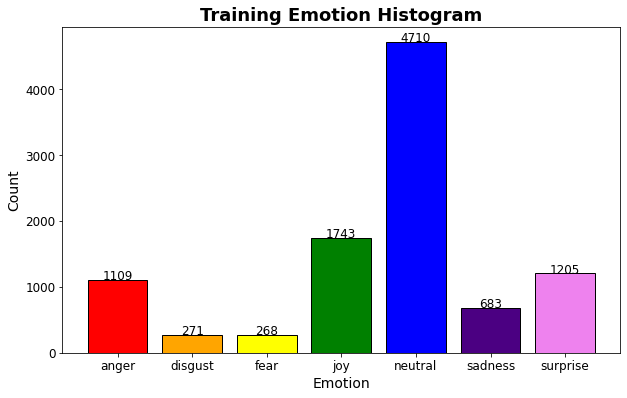

In [ ]:
ShowEmotionHistogram(train_emoCount, "Training Emotion Histogram", "Emotion", "Count")

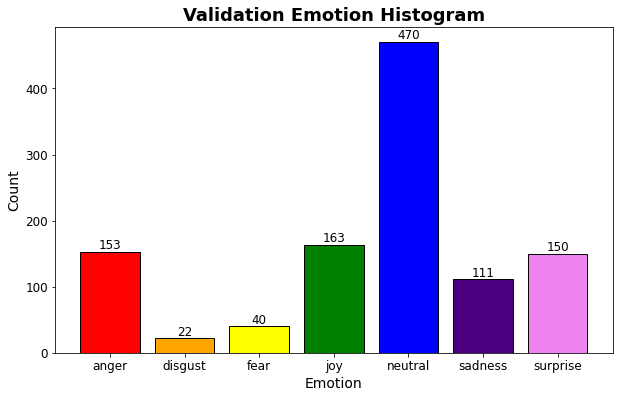

In [ ]:
ShowEmotionHistogram(valid_emoCount, "Validation Emotion Histogram", "Emotion", "Count")

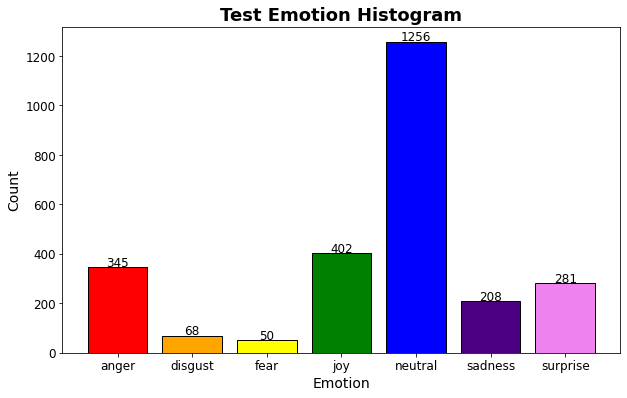

In [ ]:
ShowEmotionHistogram(test_emoCount, "Test Emotion Histogram", "Emotion", "Count")

<p align="justify"> Distributions show a big amount of samples for neutral emotion in contrast with a reduced amount of samples for fear and disgust emotions. This can be an indicator for extending the samples of some emotions (for instance with new acquisitions, data augmentation...) to avoid bias during learning.  

<p align="justify"> Similary we create instances for the audio channel analisys.

In [ ]:
train_audio_dataset = MELDDataset(annotations_folder=annotation_folder, channel_type='audio', train_mode=0, vocab=None)
valid_audio_dataset = MELDDataset(annotations_folder=annotation_folder, channel_type='audio', train_mode=1, vocab=None)
test_audio_dataset  = MELDDataset(annotations_folder=annotation_folder, channel_type='audio', train_mode=2, vocab=None)  

In [ ]:
train_audio_dataloader = DataLoader(train_audio_dataset, batch_size=hparams["batch_size_audio"], collate_fn=MELDCollator(0), shuffle=True)

In [ ]:
valid_audio_dataloader = DataLoader(valid_audio_dataset, batch_size=hparams["batch_size_audio"], collate_fn=MELDCollator(0), shuffle=False)

In [ ]:
test_audio_dataloader = DataLoader(test_audio_dataset, batch_size=hparams["batch_size_audio"], collate_fn=MELDCollator(0), shuffle=False)

<p align="justify"> On working with several channels in multimodal system, it is mandatory to take care that all channels have the same elements. For it, we provide a method to search for discrepancies based on the ids.

In [ ]:
texts_without_audio, audio_without_texts = SearchForDiscrepancies(train_dataset, train_audio_dataset)
print("TRAIN DATASET DISCREPANCIES")
print("Texts without audio:", texts_without_audio)
print("Audio without text: ", audio_without_texts)

TRAIN DATASET DISCREPANCIES
Texts without audio: []
Audio without text:  []


In [ ]:
texts_without_audio, audio_without_texts = SearchForDiscrepancies(valid_dataset, valid_audio_dataset)
print("VALIDATION DATASET DISCREPANCIES")
print("Texts without audio:", texts_without_audio)
print("Audio without text: ", audio_without_texts)


VALIDATION DATASET DISCREPANCIES
Texts without audio: []
Audio without text:  []


In [ ]:
texts_without_audio, audio_without_texts = SearchForDiscrepancies(test_dataset, test_audio_dataset)
print("TEST DATASET DISCREPANCIES")
print("Texts without audio:", texts_without_audio)
print("Audio without text: ", audio_without_texts)

TEST DATASET DISCREPANCIES
Texts without audio: []
Audio without text:  []


### **Training functions**

<p align="justify"> In order to train and evaluate the models, we have created the following functions:

In [ ]:
def accuracy(labels, outputs):
  # Calculates the computed accuracy of model's predictions given the true labels.
  # Args:  labels: tensor containing the true labels (ground truth) for a batch of data
  #        output: tensor containing the predicted labels output by the model for the same batch of data
  # Returns: accuracy of model's predictions

    preds = outputs.argmax(-1)
    acc = (preds == labels.view_as(preds)).float().detach().cpu().numpy().mean()
    return acc

<p align="justify"> F1 score is a measure of a model's performance for a multi-class classification problem, and it takes into account both the precision and recall of the model's predictions.

In [ ]:
def fscore(labels, preds):
  # Computes two types of F1 scores for a multi-class classification problem, given the true labels and predicted labels
  # Args:  labels: tensor containing the true labels (ground truth) for a batch of data
  #        preds: tensor containing the predicted labels output by the model for the same batch of data
  # Returns: F1 score and weighted average 

  fscore = MulticlassF1Score(num_classes=7, average=None).to(device)
  w_avg = MulticlassF1Score(num_classes=7, average='weighted').to(device)
  metric = fscore(preds, labels)
  weighted_avg = w_avg(preds,labels)
  
  return metric, weighted_avg

<p align="justify"> Our training, validation and test functions to train and/or evaluate a single step by the model are listed below:

In [ ]:
def train_single_epoch(model, train_loader, optimizer, channel_type= 0):
  # Performs one epoch of training for the specified model, using a provided optimizer and training data. 
  # It calculates the loss and accuracy for each batch, and returns the average loss and accuracy values for the entire epoch.
  # Args:  model: model to be trained 
  #        train_loader: DataLoader object containing the training data
  #        optimizer: optimizer used to update the model parameters during training
  #        channel_type: Indicates if the selected channel was text=0 or audio=1 to use differente type for the processed data   
  # Returns: average loss and accuracy values for the entire epoch.

  model.train()
  accs, losses = [], []
  for x, y, z in train_loader:
      optimizer.zero_grad()
      x, y = x.to(device), y.to(device)

      if (channel_type ==0):
        y_, vec = model(x)
      else:
        y_, vec = model(x.float())

      loss = F.cross_entropy(y_, y)
      loss.backward()
      optimizer.step()
      acc = accuracy(y, y_)
      losses.append(loss.item())
      accs.append(acc.item())
  return np.mean(losses), np.mean(accs)

In [ ]:
def eval_single_epoch(model, val_loader, channel_type= 0):
  # Evaluates the performance of the specified model based on the provided validation set.
  # It calculates the loss and accuracy for each batch, returning the average loss and accuracy values for the entire validation set. 
  # Args:  model: model to be evaluated 
  #        val_loader: DataLoader object containing the validation data
  #        channel_type: Indicates if the selected channel was text=0 or audio=1 to use differente type for the processed data   
  # Returns: average loss and accuracy values for the entire epoch.
  
  accs, losses = [], []
  with torch.no_grad():
      model.eval()
      for x, y, z in val_loader:
          x, y = x.to(device), y.to(device)

          if (channel_type ==0):
            y_, vec = model(x)
          else:
            y_, vec = model(x.float())

          loss = F.cross_entropy(y_, y)
          acc = accuracy(y, y_)
          losses.append(loss.item())
          accs.append(acc.item())
  return np.mean(losses), np.mean(accs)

In [ ]:
def test_single_epoch(model, test_loader, channel_type= 0):
  # Evaluates the performance of the specified model based on the provided test set.
  # It calculates the loss and accuracy for each batch, returning the average loss and accuracy values for the entire test set. 
  # It also collects the true and predicted labels for each batch, which can be used to compute evaluation metrics such as precision, recall, and F1 score.
  # Args:  model: model to be evaluated 
  #        test_loader: DataLoader object containing the test data
  #        channel_type: Indicates if the selected channel was text=0 or audio=1 to use differente type for the processed data   
  # Returns: average loss and accuracy values for the entire epoch.
  #          true and predicted labels for for the entire epoch.

  accs, losses = [], []
  lbl_truth, lbl_pred = [], []
  with torch.no_grad():
      model.eval()
      for x, y, z in test_loader:
          x, y = x.to(device), y.to(device)
          
          if (channel_type ==0):
            y_, vec = model(x)
          else:
            y_, vec = model(x.float())

          loss = F.cross_entropy(y_, y)
          acc = accuracy(y, y_)
          losses.append(loss.item())
          accs.append(acc.item())
          
          lbl_truth.append(y.cpu().numpy())            #For metrics
          lbl_pred.append(y_.argmax(-1).cpu().numpy()) #For metrics

  return np.mean(losses), np.mean(accs), lbl_truth, lbl_pred

<p align="justify"> Finally, using the previous functions we provide the main trainining and evaluation function for the model. 

In [ ]:
def train_model(model, classes, train_loader, val_loader, test_loader, channel_type= 0):
  # Trains and evaluates the specified model on three sets of data: train, validation and test. 
  # After training, the model is evaluated on the test set, calculating F1 score and weighted average 
  # Finally, a confusion matrix is generated and saved as image.
  # Args:  model: model to be evaluated 
  #        classes: list of emotions
  #        train_loader: DataLoader object containing the training data
  #        val_loader: DataLoader object containing the validation data
  #        test_loader: DataLoader object containing the test data
  #        channel_type: Indicates if the selected channel was text=0 or audio=1 to use differente type for the processed data   
  # Returns:  the model with the calculated training losses and accuracy and the validation losses and accuracy
    
  optimizer = optim.Adam(model.parameters(), hparams["lr"])
  train_accs = []
  train_losses = []
  val_accs = []
  val_losses =[]
  for epoch in range(hparams["epochs"]):
      loss, acc = train_single_epoch(model, train_loader, optimizer, channel_type)
      train_losses.append(loss)
      train_accs.append(acc)
      print(f"Train Epoch {epoch} loss={loss:.2f} acc={acc:.2f}")
      loss, acc = eval_single_epoch(model, val_loader, channel_type)
      val_losses.append(loss)
      val_accs.append(acc)
      print(f"Eval Epoch {epoch} loss={loss:.2f} acc={acc:.2f}")
  
  loss, acc, target, preds = test_single_epoch(model, test_loader, channel_type)
  print("\n")
  print(f"Test loss={loss:.2f} acc={acc:.2f}")
  print("\n")

  target = torch.tensor(list(itertools.chain(*target))).to(device)
  preds = torch.tensor(list(itertools.chain(*preds))).to(device)
  f_score, weighted_avg = fscore(target, preds)
  print("Test fscore: ", f_score.tolist())
  print("Test weighted average: ", weighted_avg.tolist())
  print("\n")

    # Build confusion matrix
  cf_matrix = confusion_matrix(target.cpu().numpy(), preds.cpu().numpy())
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                    columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  plt.savefig('output.png')

  return model, train_losses, train_accs, val_losses, val_accs


## **First step: Learning from indivual samples**

<p align="justify"> As first step for our analysis, we have colllected the samples in batches by its length, without considering the dialogue context and we have learn the emotional features individually. 
<p align="justify"> We have implemented several models in order to learn in depth about every special tecnique and be able to compare it for this specific problem.   

In [ ]:
nEmotions  = len(train_dataset.getEmotionDict())
nVocabSize = train_dataset.getVocabularySize()
classes = tuple(train_dataset.getEmotionDict().keys())

### **1) Simple MLP Classifier model**

<p align="justify"> The first approach that we have performed has been based on the simple MLP Classifier described previously.

In [ ]:
mlpmodel = MELDTextClassifierMLP(nVocabSize, embedding_dim=64, hidden_size=128, n_emotions=nEmotions)
mlpmodel.to(device)

MELDTextClassifierMLP(
  (embeddings): Embedding(6016, 64, padding_idx=0)
  (mlp): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=64, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (classifier): Linear(in_features=128, out_features=7, bias=True)
)

Train Epoch 0 loss=1.41 acc=0.53
Eval Epoch 0 loss=1.42 acc=0.52
Train Epoch 1 loss=1.34 acc=0.55
Eval Epoch 1 loss=1.38 acc=0.53
Train Epoch 2 loss=1.31 acc=0.56
Eval Epoch 2 loss=1.36 acc=0.53
Train Epoch 3 loss=1.28 acc=0.57
Eval Epoch 3 loss=1.35 acc=0.53
Train Epoch 4 loss=1.26 acc=0.58
Eval Epoch 4 loss=1.33 acc=0.54
Train Epoch 5 loss=1.24 acc=0.58
Eval Epoch 5 loss=1.33 acc=0.55
Train Epoch 6 loss=1.22 acc=0.59
Eval Epoch 6 loss=1.32 acc=0.54
Train Epoch 7 loss=1.19 acc=0.60
Eval Epoch 7 loss=1.32 acc=0.54
Train Epoch 8 loss=1.17 acc=0.60
Eval Epoch 8 loss=1.32 acc=0.56
Train Epoch 9 loss=1.16 acc=0.61
Eval Epoch 9 loss=1.33 acc=0.54


Test loss=1.24 acc=0.58


Test fscore:  [0.75, 0.5085803270339966, 0.0, 0.12451361864805222, 0.4856512248516083, 0.028985507786273956, 0.2873345911502838]
Test weighted average:  0.5391352772712708




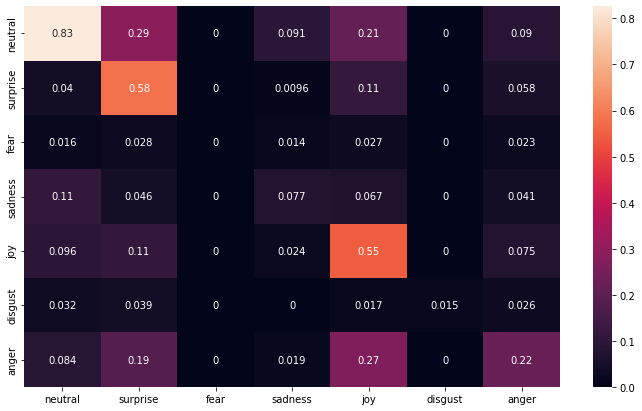

In [ ]:
mlpmodel_out, mlptrain_losses, mlptrain_accs, mlpval_losses, mlpval_accs = train_model(mlpmodel, classes, train_dataloader, valid_dataloader, test_dataloader)

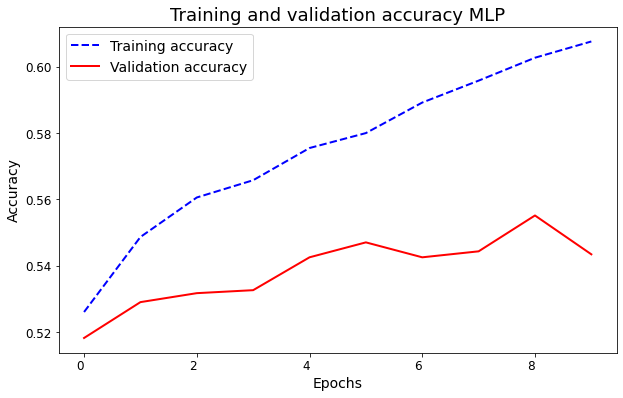

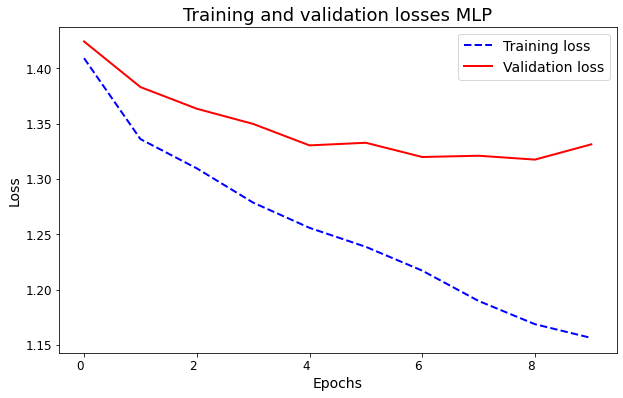

In [ ]:
epochs = range(len(mlptrain_accs))
Show2Trends2D(epochs, mlptrain_accs, 'Training accuracy', epochs, mlpval_accs, 'Validation accuracy', 'Training and validation accuracy MLP', 'Epochs', 'Accuracy', 'acc.jpg')
Show2Trends2D(epochs, mlptrain_losses, 'Training loss', epochs, mlpval_losses, 'Validation loss', 'Training and validation losses MLP', 'Epochs', 'Loss', 'loss.jpg')


### **2) Simple Text LSTM classifier**


<p align="justify"> The second approach has been based on the simple LSTM Classifier described previously.

In [ ]:
lstmmodel = MELDTextClassifierLSTM(nVocabSize, embedding_dim=32)
lstmmodel.to(device)

MELDTextClassifierLSTM(
  (embeddings): Embedding(6016, 32, padding_idx=0)
  (LSTM): LSTM(32, 32, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (classifier): Linear(in_features=64, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Train Epoch 0 loss=1.43 acc=0.52
Eval Epoch 0 loss=1.42 acc=0.51
Train Epoch 1 loss=1.32 acc=0.56
Eval Epoch 1 loss=1.39 acc=0.52
Train Epoch 2 loss=1.29 acc=0.57
Eval Epoch 2 loss=1.38 acc=0.53
Train Epoch 3 loss=1.26 acc=0.58
Eval Epoch 3 loss=1.36 acc=0.54
Train Epoch 4 loss=1.24 acc=0.58
Eval Epoch 4 loss=1.35 acc=0.55
Train Epoch 5 loss=1.23 acc=0.59
Eval Epoch 5 loss=1.35 acc=0.54
Train Epoch 6 loss=1.21 acc=0.59
Eval Epoch 6 loss=1.35 acc=0.55
Train Epoch 7 loss=1.20 acc=0.60
Eval Epoch 7 loss=1.34 acc=0.56
Train Epoch 8 loss=1.19 acc=0.60
Eval Epoch 8 loss=1.32 acc=0.55
Train Epoch 9 loss=1.16 acc=0.61
Eval Epoch 9 loss=1.33 acc=0.56


Test loss=1.20 acc=0.60


Test fscore:  [0.7690714597702026, 0.49501660466194153, 0.0, 0.13114753365516663, 0.47121819853782654, 0.0, 0.38562092185020447]
Test weighted average:  0.5573950409889221




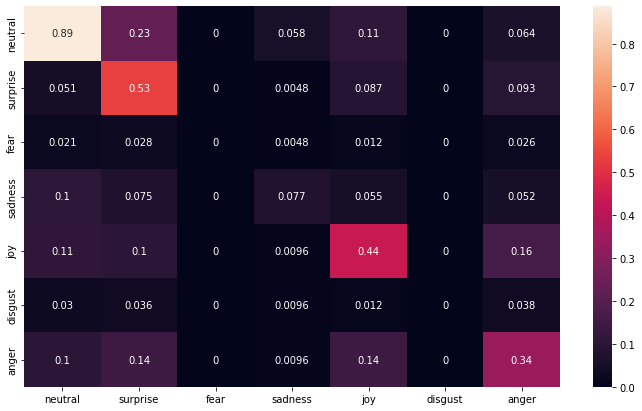

In [ ]:
lstmmodel_out, lstmtrain_losses, lstmtrain_accs, lstmval_losses, lstmval_accs = train_model(lstmmodel, classes, train_dataloader, valid_dataloader, test_dataloader)

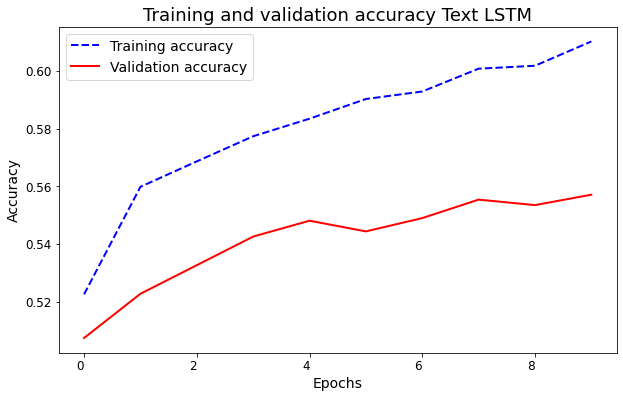

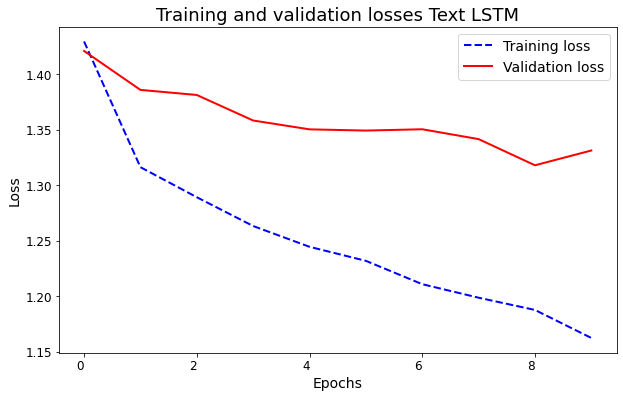

In [ ]:
epochs = range(len(lstmtrain_accs))
Show2Trends2D(epochs, lstmtrain_accs, 'Training accuracy', epochs, lstmval_accs, 'Validation accuracy', 'Training and validation accuracy Text LSTM', 'Epochs', 'Accuracy', 'acc_LSTM.jpg')
Show2Trends2D(epochs, lstmtrain_losses, 'Training loss', epochs, lstmval_losses, 'Validation loss', 'Training and validation losses Text LSTM', 'Epochs', 'Loss', 'loss_LSTM.jpg')


### **3) Simple Audio LSTM classifier**

For the audio classifier we changed the following two hyperparameters: 

In [ ]:
hparams["epochs"]=100
hparams["lr"]=1e-5

In [ ]:
audiolstmmodel = MELDAudioClassifierLSTM(embedding_dim=1611, num_layers=2)
audiolstmmodel.to(device)

MELDAudioClassifierLSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (LSTM): LSTM(1611, 300, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (classifier): Linear(in_features=600, out_features=7, bias=True)
)

Train Epoch 0 loss=1.62 acc=0.46
Eval Epoch 0 loss=1.66 acc=0.42
Train Epoch 1 loss=1.54 acc=0.47
Eval Epoch 1 loss=1.65 acc=0.42
Train Epoch 2 loss=1.54 acc=0.47
Eval Epoch 2 loss=1.65 acc=0.42
Train Epoch 3 loss=1.54 acc=0.47
Eval Epoch 3 loss=1.65 acc=0.42
Train Epoch 4 loss=1.54 acc=0.47
Eval Epoch 4 loss=1.65 acc=0.42
Train Epoch 5 loss=1.54 acc=0.47
Eval Epoch 5 loss=1.65 acc=0.42
Train Epoch 6 loss=1.54 acc=0.47
Eval Epoch 6 loss=1.66 acc=0.42
Train Epoch 7 loss=1.54 acc=0.47
Eval Epoch 7 loss=1.64 acc=0.42
Train Epoch 8 loss=1.54 acc=0.47
Eval Epoch 8 loss=1.64 acc=0.42
Train Epoch 9 loss=1.54 acc=0.47
Eval Epoch 9 loss=1.65 acc=0.42
Train Epoch 10 loss=1.54 acc=0.47
Eval Epoch 10 loss=1.64 acc=0.42
Train Epoch 11 loss=1.54 acc=0.47
Eval Epoch 11 loss=1.65 acc=0.42
Train Epoch 12 loss=1.54 acc=0.47
Eval Epoch 12 loss=1.65 acc=0.42
Train Epoch 13 loss=1.54 acc=0.47
Eval Epoch 13 loss=1.65 acc=0.42
Train Epoch 14 loss=1.54 acc=0.47
Eval Epoch 14 loss=1.64 acc=0.42
Train Epoch 15 

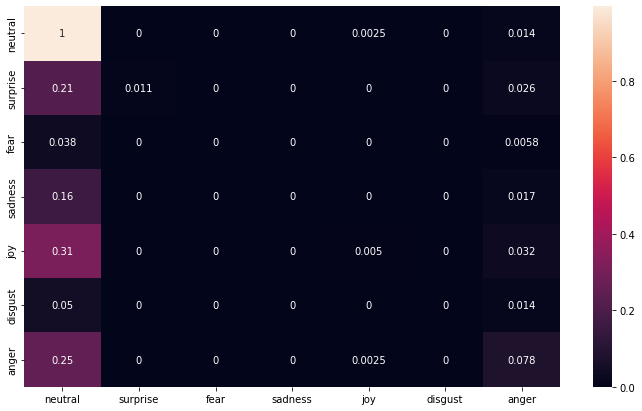

In [ ]:
audiolstmmodel_out, audiolstmtrain_losses, audiolstmtrain_accs, audiolstmval_losses, audiolstmval_accs = train_model(audiolstmmodel, classes, train_audio_dataloader, valid_audio_dataloader, test_audio_dataloader, channel_type=1)

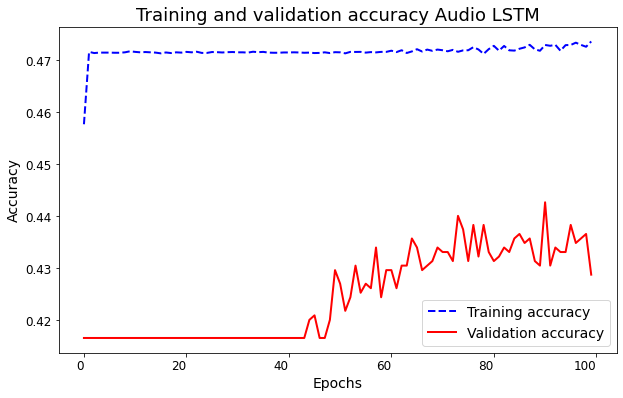

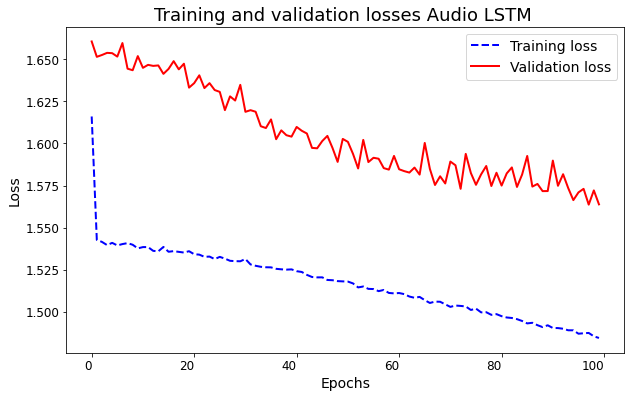

In [ ]:
epochs = range(len(audiolstmtrain_accs))
Show2Trends2D(epochs, audiolstmtrain_accs, 'Training accuracy', epochs, audiolstmval_accs, 'Validation accuracy', 'Training and validation accuracy Audio LSTM', 'Epochs', 'Accuracy', 'audioacc_LSTM.jpg')
Show2Trends2D(epochs, audiolstmtrain_losses, 'Training loss', epochs, audiolstmval_losses, 'Validation loss', 'Training and validation losses Audio LSTM ', 'Epochs', 'Loss', 'audioloss_LSTM.jpg')


### **4) Simple Transformer Encoder**

As the transformer deals with text, we go back to the hyperparameters we had:

In [ ]:
hparams["epochs"]=10
hparams["lr"]=1e-3

In [ ]:
Tmodel = MELDTextClassifierTransformer(6085, embedding_dim=128, heads=8, num_encoders=2)
Tmodel.to(device)

MELDTextClassifierTransformer(
  (emb): Embedding(6085, 128, padding_idx=0)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (trans_encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (trans_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=Tr

Train Epoch 0 loss=1.38 acc=0.54
Eval Epoch 0 loss=1.36 acc=0.54
Train Epoch 1 loss=1.31 acc=0.57
Eval Epoch 1 loss=1.39 acc=0.52
Train Epoch 2 loss=1.29 acc=0.57
Eval Epoch 2 loss=1.36 acc=0.55
Train Epoch 3 loss=1.28 acc=0.58
Eval Epoch 3 loss=1.37 acc=0.54
Train Epoch 4 loss=1.26 acc=0.58
Eval Epoch 4 loss=1.39 acc=0.53
Train Epoch 5 loss=1.26 acc=0.59
Eval Epoch 5 loss=1.36 acc=0.55
Train Epoch 6 loss=1.26 acc=0.59
Eval Epoch 6 loss=1.33 acc=0.54
Train Epoch 7 loss=1.24 acc=0.59
Eval Epoch 7 loss=1.35 acc=0.56
Train Epoch 8 loss=1.24 acc=0.59
Eval Epoch 8 loss=1.34 acc=0.56
Train Epoch 9 loss=1.23 acc=0.59
Eval Epoch 9 loss=1.31 acc=0.56


Test loss=1.21 acc=0.60


Test fscore:  [0.7719180583953857, 0.46783626079559326, 0.0, 0.11063829809427261, 0.4496551752090454, 0.0, 0.3987730145454407]
Test weighted average:  0.5526214241981506




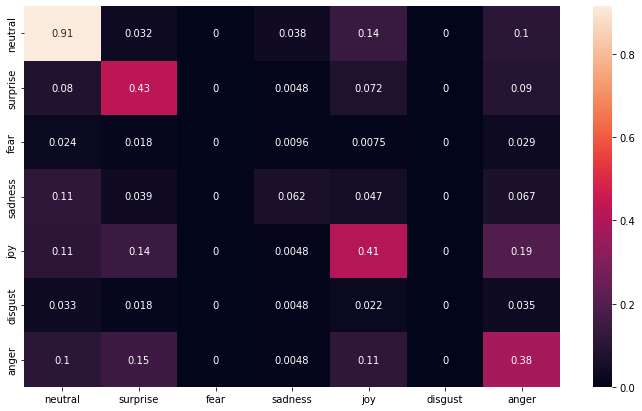

In [ ]:
Tmodel_out, Ttrain_losses, Ttrain_accs, Tval_losses, Tval_accs = train_model(Tmodel, classes, train_dataloader, valid_dataloader, test_dataloader)

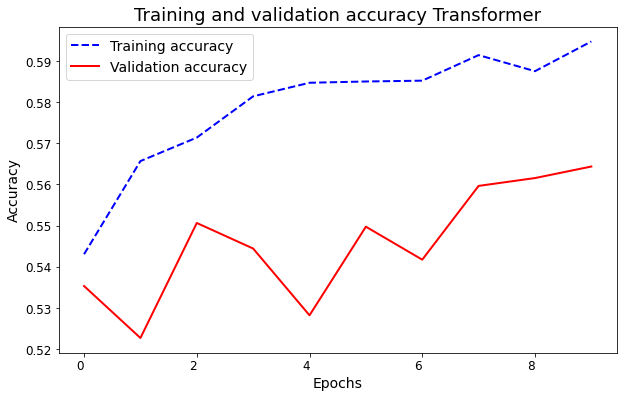

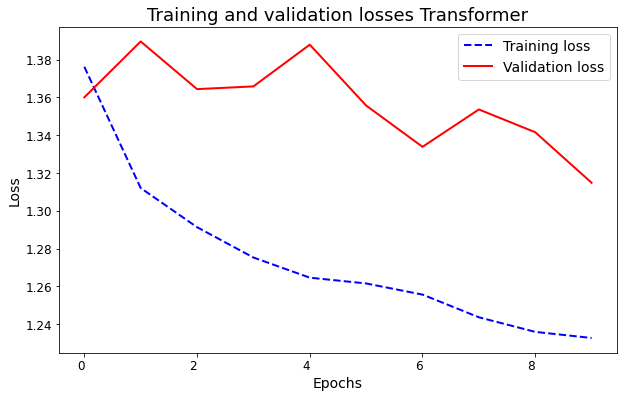

In [ ]:
epochs = range(len(Ttrain_accs))
Show2Trends2D(epochs, Ttrain_accs, 'Training accuracy', epochs, Tval_accs, 'Validation accuracy', 'Training and validation accuracy Transformer', 'Epochs', 'Accuracy', 'acc_Encoder.jpg')
Show2Trends2D(epochs, Ttrain_losses, 'Training loss', epochs, Tval_losses, 'Validation loss', 'Training and validation losses Transformer', 'Epochs', 'Loss', 'loss_Encoder.jpg')


## **Second step: Working on dialogue-level**

<p align="justify"> Once it was finished the individual learning, we are interested to analyze the impact of the context by the emotion recognition. For this, we have decided to reorder the extracted features (all from same length), considering the temporal occurrence  to get extra information directly from the dialogue context. 

<p align="justify"> For simplicity in the next steps, we have chosen the text and audio LSTM models, because they have offered the best relation accuracy-performance between all the previous tested models.  

In [ ]:
def feature_extractor(model, loader, channel_type= 0):
  # Extracts the features from the provided model for the specific loader
  # Args: model:   model used to extract features from data. 
  #       loader:  data loader used to load the data that the features will be extracted from.
  #       channel_type: Indicates if the selected channel was text=0 or audio=1 to use differente type for the processed data   
  # Returns flattened lists as a tuple containing the features, the associated labels and the corrsponding feature IDs.

  feature_vectors = []
  feature_vectors_ID = []
  feature_vectors_lbl = []

  model.eval()
  for x, y, z in loader:
    y, z = y.cpu().numpy(), z.cpu().numpy()
    x = x.to(device)

    if (channel_type ==0):
      y_, vectors = model(x)
    else:
      y_, vectors = model(x.float())

    vectors = vectors.detach().cpu().numpy()
    
    feature_vectors.append(vectors)
    feature_vectors_lbl.append(y)
    feature_vectors_ID.append(z)
  
  feature_vectors = list(itertools.chain(*feature_vectors))
  feature_vectors_lbl = list(itertools.chain(*feature_vectors_lbl))
  feature_vectors_ID = list(itertools.chain(*feature_vectors_ID))

  return feature_vectors, feature_vectors_lbl, feature_vectors_ID


In [ ]:
def reorder(feature_vectors, feature_vectors_lbl, feature_vectors_ID):
  ### This function: 
  # 1) orders according to dialogue
  # 2) make sublists with all utterances of a dialogue together
  # 3) orders according to utterance inside the sublist
  
  # 1)
  indices = [(i, s[0]) for i, s in enumerate(feature_vectors_ID)]  
  indices.sort(key=lambda x: x[1])
  pooled_indices = [x[0] for x in indices] 
  vector_ids_2 = []
  vector_data_2 = []
  vector_lbl_2 = []
  for i in range(len(pooled_indices)):
    idx = pooled_indices[i]
    vector_ids_2.append(feature_vectors_ID[idx])
    vector_data_2.append(feature_vectors[idx])
    vector_lbl_2.append(feature_vectors_lbl[idx])
  
  # 2)
  vector_ids_3 = [[]]
  vector_data_3 = [[]]
  vector_lbl_3 = [[]]
  idx = 0
  for i in range(len(vector_ids_2)):
    if i == 0:
      vector_ids_3[idx].append(vector_ids_2[i])
      vector_data_3[idx].append(vector_data_2[i])
      vector_lbl_3[idx].append(vector_lbl_2[i])
    else:
      j = i-1
      if vector_ids_2[i][0] == vector_ids_2[j][0]:
        vector_ids_3[idx].append(vector_ids_2[i])
        vector_data_3[idx].append(vector_data_2[i])
        vector_lbl_3[idx].append(vector_lbl_2[i])

      else:
        idx += 1
        vector_ids_3.append([vector_ids_2[i]])
        vector_data_3.append([vector_data_2[i]])
        vector_lbl_3.append([vector_lbl_2[i]])
    
  # 3)
  feature_vectors_ID_sorted = copy.deepcopy(vector_ids_3) 
  feature_vectors_sorted = copy.deepcopy(vector_data_3) 
  feature_vectors_lbl_sorted = copy.deepcopy(vector_lbl_3)  

  for i in range(len(vector_ids_3)):
    indices = [(j, s[1]) for j, s in enumerate(vector_ids_3[i])]
    indices.sort(key=lambda x: x[1])
    pooled_indices = [x[0] for x in indices] 
    for k in range(len(pooled_indices)):
      idx = pooled_indices[k]
      feature_vectors_ID_sorted[i][k] = vector_ids_3[i][idx]
      feature_vectors_sorted[i][k] = vector_data_3[i][idx]
      feature_vectors_lbl_sorted[i][k] = vector_lbl_3[i][idx]
  
  return feature_vectors_sorted, feature_vectors_lbl_sorted, feature_vectors_ID_sorted

<p align="justify"> Extract the features (data, label and IDs) from our text model:

In [ ]:
feature_text_vectors_train, feature_text_vectors_train_lbl, feature_text_vectors_train_ID = feature_extractor(lstmmodel_out, train_dataloader)
feature_text_vectors_val,   feature_text_vectors_val_lbl,   feature_text_vectors_val_ID   = feature_extractor(lstmmodel_out, valid_dataloader)
feature_text_vectors_test,  feature_text_vectors_test_lbl,  feature_text_vectors_test_ID  = feature_extractor(lstmmodel_out, test_dataloader)

<p align="justify"> Use the provided reorder method to order the features depending of their temporal occurrence (defined by the ids).

In [ ]:
feature_text_vectors_train_sorted, feature_text_vectors_train_lbl_sorted, feature_text_vectors_train_ID_sorted = reorder(feature_text_vectors_train, feature_text_vectors_train_lbl, feature_text_vectors_train_ID)
feature_text_vectors_val_sorted,   feature_text_vectors_val_lbl_sorted,   feature_text_vectors_val_ID_sorted   = reorder(feature_text_vectors_val,   feature_text_vectors_val_lbl,   feature_text_vectors_val_ID)
feature_text_vectors_test_sorted,  feature_text_vectors_test_lbl_sorted,  feature_text_vectors_test_ID_sorted  = reorder(feature_text_vectors_test,  feature_text_vectors_test_lbl,  feature_text_vectors_test_ID)

<p align="justify"> As for previous steps, now we define a specialized Dataset and Dataloader to manage the dialogue contexts. 

In [ ]:
class DialogueMELDDataset(Dataset):
# Dataset class to support the dialogue MELD data. 
  #----------------------------------------------------------------------------------------
  # Method: DialogueMELDDataset.init
  # Constructor of the MELDDataset class 
  #----------------------------------------------------------------------------------------
  def __init__(self, vector, lbl, ID):
    self.vector = vector
    self.lbl = lbl 
    self.ID = ID
  
  #----------------------------------------------------------------------------------------
  # Method: DialogueMELDDataset.len
  # Returns the number of elements of the dataset
  #----------------------------------------------------------------------------------------
  def __len__(self):
    length = len(self.vector)
    return length
  
  #----------------------------------------------------------------------------------------
  #Method: DialogueMELDDataset.getitem
  # Returns the element of the dataset specified by the index
  #     - feature vector,  labeled emotion, utterance id  
  #----------------------------------------------------------------------------------------  
  def __getitem__(self, idx):
    return self.vector[idx], self.lbl[idx], self.ID[idx]

<p align="justify"> We use the collation mechanism to provide a specific function unpack_dialogue unformation. This function doesn't do any meaningful collation. It simply extracts the tensors from each tuple in the batch and overwrites the same-named variables with the last values seen in the loop. 

In [ ]:
def unpack_dialogue(batch):
  # 
   for (_vector, _label, _ID) in batch:
     label = _label
     ID = _ID
     vector = _vector

   return torch.tensor(vector), torch.tensor(label), torch.tensor(ID)

In [ ]:
train_text_features = DialogueMELDDataset(feature_text_vectors_train_sorted, feature_text_vectors_train_lbl_sorted, feature_text_vectors_train_ID_sorted)
val_text_features   = DialogueMELDDataset(feature_text_vectors_val_sorted,   feature_text_vectors_val_lbl_sorted,   feature_text_vectors_val_ID_sorted)
test_text_features  = DialogueMELDDataset(feature_text_vectors_test_sorted,  feature_text_vectors_test_lbl_sorted,  feature_text_vectors_test_ID_sorted)

<p align="justify"> We set the batch size to 1 in order to analize the context dialogue by dialogue.

In [ ]:
train_text_features_loader = DataLoader(train_text_features, batch_size=1, shuffle=True,  collate_fn=unpack_dialogue)
val_text_features_loader   = DataLoader(val_text_features,   batch_size=1, shuffle=False, collate_fn=unpack_dialogue)
test_text_features_loader  = DataLoader(test_text_features,  batch_size=1, shuffle=False, collate_fn=unpack_dialogue)

### **Dialogue-Context Classifier**

<p align="justify"> We apply our DialogueContextClassifier to see if we can enhance our accurancy based on the context analysis.

In [ ]:
class DialogueContextClassifier(nn.Module):

    def __init__(self, vec_dim) -> None:
      super().__init__()

      self.LSTM = nn.LSTM(vec_dim, vec_dim, num_layers=2, bidirectional=False, batch_first=True, dropout=0.3)

      self.classifier = nn.Linear(vec_dim, 7)

      self.dropout = nn.Dropout(0.5)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      # size(x) = (nº utterance/dialogue, vec_dim)  (B=1 does not appear)

      x = self.dropout(x)
      x, state = self.LSTM(x)  # size(x) : (nº utterance/dialogue, vec_dim)    
      y = self.classifier(x)   # size(y) : (nº utterance/dialogue, number of emotion = 7)   

      return y, x

In [ ]:
context_text_model = DialogueContextClassifier(vec_dim=64)
context_text_model.to(device)

DialogueContextClassifier(
  (LSTM): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.3)
  (classifier): Linear(in_features=64, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

<ipython-input-75-bd7cc1b0c24d>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.tensor(vector), torch.tensor(label), torch.tensor(ID)


Train Epoch 0 loss=1.24 acc=0.60
Eval Epoch 0 loss=1.32 acc=0.56
Train Epoch 1 loss=1.11 acc=0.64
Eval Epoch 1 loss=1.31 acc=0.57
Train Epoch 2 loss=1.10 acc=0.65
Eval Epoch 2 loss=1.28 acc=0.59
Train Epoch 3 loss=1.09 acc=0.65
Eval Epoch 3 loss=1.28 acc=0.57
Train Epoch 4 loss=1.07 acc=0.66
Eval Epoch 4 loss=1.32 acc=0.57
Train Epoch 5 loss=1.06 acc=0.66
Eval Epoch 5 loss=1.30 acc=0.57
Train Epoch 6 loss=1.07 acc=0.65
Eval Epoch 6 loss=1.30 acc=0.57
Train Epoch 7 loss=1.06 acc=0.66
Eval Epoch 7 loss=1.30 acc=0.58
Train Epoch 8 loss=1.05 acc=0.66
Eval Epoch 8 loss=1.31 acc=0.58
Train Epoch 9 loss=1.05 acc=0.66
Eval Epoch 9 loss=1.30 acc=0.58


Test loss=1.21 acc=0.62


Test fscore:  [0.7681356072425842, 0.5027523040771484, 0.0, 0.15325669944286346, 0.4905149042606354, 0.0, 0.39144736528396606]
Test weighted average:  0.5632818341255188




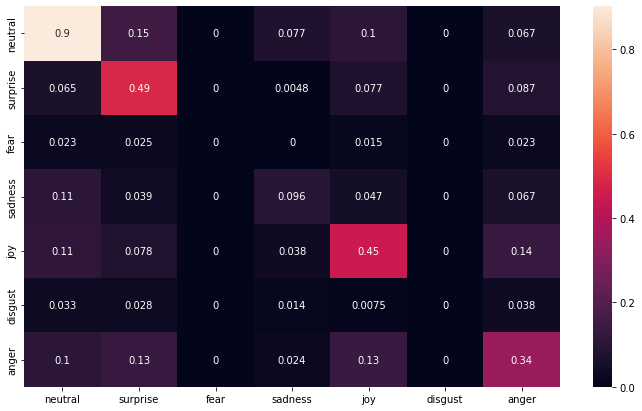

In [ ]:
context_text_model_out, train_losses2, train_accs2, val_losses2, val_accs2 = train_model(context_text_model, classes, train_text_features_loader, val_text_features_loader, test_text_features_loader)

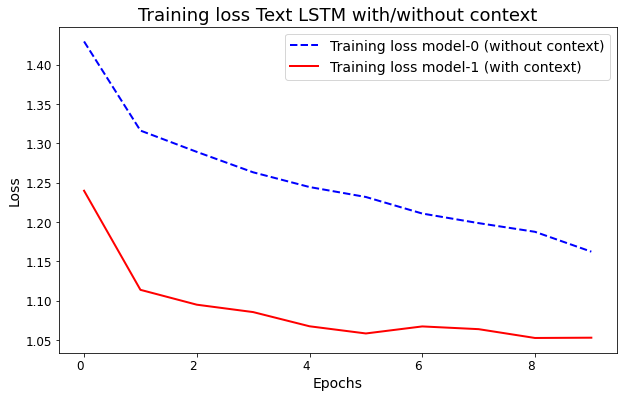

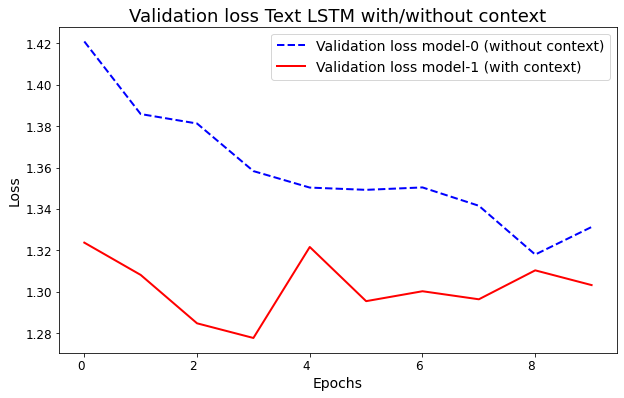

In [ ]:
epochs = range(len(lstmtrain_losses))
epochs2 = range(len(train_losses2))

Show2Trends2D(epochs, lstmtrain_losses, 'Training loss model-0 (without context)', epochs2, train_losses2, 'Training loss model-1 (with context)', 'Training loss Text LSTM with/without context', 'Epochs', 'Loss', 'train_loss_models.jpg')
Show2Trends2D(epochs, lstmval_losses, 'Validation loss model-0 (without context)', epochs2, val_losses2, 'Validation loss model-1 (with context)', 'Validation loss Text LSTM with/without context', 'Epochs', 'Loss', 'val_loss_models.jpg')


<p align="justify"> Based on the comparition, the text model enriched with the temporal context shows better results than the same model without context information.

<p align="justify"> So we can repeat the process with the audio model to prove that the context has a positive impact in this case too.


In [ ]:
feature_audio_vectors_train, feature_audio_vectors_train_lbl, feature_audio_vectors_train_ID = feature_extractor(audiolstmmodel_out, train_audio_dataloader, channel_type=1)
feature_audio_vectors_val,   feature_audio_vectors_val_lbl,   feature_audio_vectors_val_ID   = feature_extractor(audiolstmmodel_out, valid_audio_dataloader, channel_type=1)
feature_audio_vectors_test,  feature_audio_vectors_test_lbl,  feature_audio_vectors_test_ID  = feature_extractor(audiolstmmodel_out, test_audio_dataloader, channel_type=1)

In [ ]:
feature_audio_vectors_train_sorted, feature_audio_vectors_train_lbl_sorted, feature_audio_vectors_train_ID_sorted = reorder(feature_audio_vectors_train, feature_audio_vectors_train_lbl, feature_audio_vectors_train_ID)
feature_audio_vectors_val_sorted,   feature_audio_vectors_val_lbl_sorted,   feature_audio_vectors_val_ID_sorted   = reorder(feature_audio_vectors_val, feature_audio_vectors_val_lbl, feature_audio_vectors_val_ID)
feature_audio_vectors_test_sorted,  feature_audio_vectors_test_lbl_sorted,  feature_audio_vectors_test_ID_sorted  = reorder(feature_audio_vectors_test, feature_audio_vectors_test_lbl, feature_audio_vectors_test_ID)

In [ ]:
train_audio_features = DialogueMELDDataset(feature_audio_vectors_train_sorted, feature_audio_vectors_train_lbl_sorted, feature_audio_vectors_train_ID_sorted)
val_audio_features   = DialogueMELDDataset(feature_audio_vectors_val_sorted,   feature_audio_vectors_val_lbl_sorted,   feature_audio_vectors_val_ID_sorted)
test_audio_features  = DialogueMELDDataset(feature_audio_vectors_test_sorted,  feature_audio_vectors_test_lbl_sorted,  feature_audio_vectors_test_ID_sorted)

In [ ]:
train_audio_features_loader = DataLoader(train_audio_features, batch_size=1, shuffle=True,  collate_fn=unpack_dialogue)
val_audio_features_loader   = DataLoader(val_audio_features,   batch_size=1, shuffle=False, collate_fn=unpack_dialogue)
test_audio_features_loader  = DataLoader(test_audio_features,  batch_size=1, shuffle=False, collate_fn=unpack_dialogue)

In [ ]:
context_audio_model = DialogueContextClassifier(vec_dim=600)
context_audio_model.to(device)


DialogueContextClassifier(
  (LSTM): LSTM(600, 600, num_layers=2, batch_first=True, dropout=0.3)
  (classifier): Linear(in_features=600, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
hparams["epochs"]=30

In [ ]:
hparams["lr"]=1e-5

Train Epoch 0 loss=1.65 acc=0.47
Eval Epoch 0 loss=1.63 acc=0.45
Train Epoch 1 loss=1.55 acc=0.48
Eval Epoch 1 loss=1.59 acc=0.45
Train Epoch 2 loss=1.52 acc=0.48
Eval Epoch 2 loss=1.57 acc=0.45
Train Epoch 3 loss=1.50 acc=0.48
Eval Epoch 3 loss=1.57 acc=0.45
Train Epoch 4 loss=1.50 acc=0.48
Eval Epoch 4 loss=1.56 acc=0.45
Train Epoch 5 loss=1.49 acc=0.48
Eval Epoch 5 loss=1.56 acc=0.46
Train Epoch 6 loss=1.49 acc=0.48
Eval Epoch 6 loss=1.56 acc=0.46
Train Epoch 7 loss=1.48 acc=0.48
Eval Epoch 7 loss=1.55 acc=0.46
Train Epoch 8 loss=1.48 acc=0.48
Eval Epoch 8 loss=1.57 acc=0.45
Train Epoch 9 loss=1.48 acc=0.49
Eval Epoch 9 loss=1.57 acc=0.45
Train Epoch 10 loss=1.48 acc=0.49
Eval Epoch 10 loss=1.55 acc=0.46
Train Epoch 11 loss=1.47 acc=0.49
Eval Epoch 11 loss=1.59 acc=0.43
Train Epoch 12 loss=1.47 acc=0.49
Eval Epoch 12 loss=1.57 acc=0.44
Train Epoch 13 loss=1.47 acc=0.49
Eval Epoch 13 loss=1.56 acc=0.45
Train Epoch 14 loss=1.47 acc=0.49
Eval Epoch 14 loss=1.56 acc=0.46
Train Epoch 15 

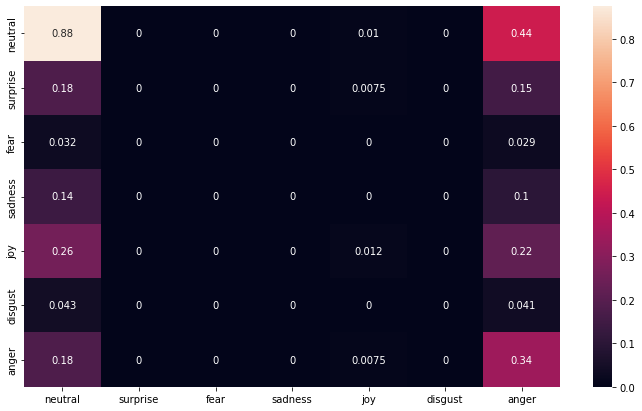

In [ ]:
context_audio_model_out, train_losses3, train_accs3, val_losses3, val_accs3 = train_model(context_audio_model, classes, train_audio_features_loader, val_audio_features_loader, test_audio_features_loader, channel_type=1)

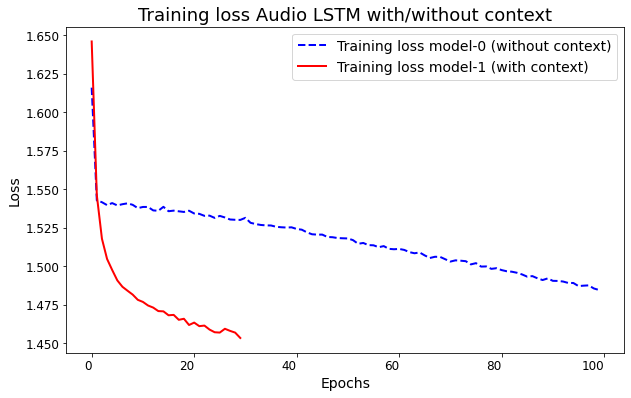

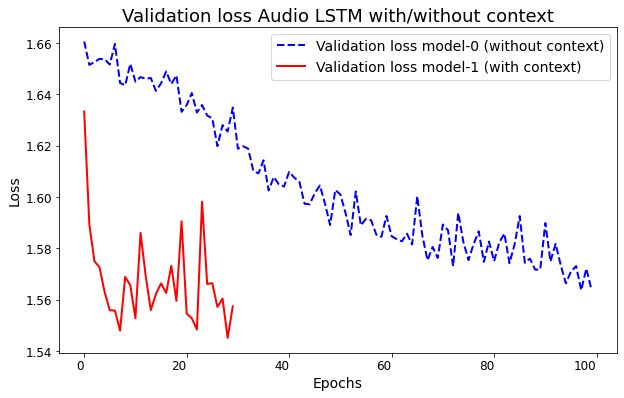

In [ ]:
epochs = range(len(audiolstmtrain_losses))
epochs2 = range(len(train_losses3))

Show2Trends2D(epochs, audiolstmtrain_losses, 'Training loss model-0 (without context)', epochs2, train_losses3, 'Training loss model-1 (with context)', 'Training loss Audio LSTM with/without context', 'Epochs', 'Loss', 'audio_train_loss_models.jpg')
Show2Trends2D(epochs, audiolstmval_losses, 'Validation loss model-0 (without context)', epochs2, val_losses3, 'Validation loss model-1 (with context)', 'Validation loss Audio LSTM with/without context', 'Epochs', 'Loss', 'audio_val_loss_models.jpg')


## **Third step: Multimodal**

<p align="justify"> Finally we want to combine the extracted audio and text features, and specifically the processed ones with context, to enhace definitively our model.

In [ ]:
class MultimodalMELDDataset(object):
# Dataset class to support the multimodal MELD data. 
  #----------------------------------------------------------------------------------------
  # Method: MultimodalMELDDataset.init
  # Constructor of the MultimodalMELDDataset class 
  #----------------------------------------------------------------------------------------
  def __init__(self, text_features, audio_features, labels, ids):
    #-----------------------------------------------------------------------
    # Initialization of member variables of the Dataset class
    #-----------------------------------------------------------------------

    # Fixed dictionary for emotions
    self.emo_dict    = {'neutral': 0, 'surprise': 1, 'fear': 2, 'sadness': 3, 'joy': 4, 'disgust': 5, 'anger': 6}
    self.emo_counter = {'neutral': 0, 'surprise': 0, 'fear': 0, 'sadness': 0, 'joy': 0, 'disgust': 0, 'anger': 0}

    self.emo_labels = labels
    self.utterance_ids = ids
    self.len = len(ids)
    self.audio_features = audio_features
    self.text_features = text_features
    return


  #----------------------------------------------------------------------------------------
  # Method: MultimodalMELDDataset.len
  # Returns the number of elements of the dataset
  #----------------------------------------------------------------------------------------
  def __len__(self):
    return self.len


  #----------------------------------------------------------------------------------------
  #Method: MultimodalMELDDataset.getitem
  # Returns the element of the dataset specified by the index
  #     - combined features, labeled emotion, utterance id  
  #----------------------------------------------------------------------------------------
  def __getitem__(self, idx):
      vector = [np.concatenate((m,n)) for m,n in zip(self.text_features[idx],self.audio_features[idx])]
      return vector, \
             self.emo_labels[idx], \
             self.utterance_ids[idx]



In [ ]:
feature_text_train, feature_text_train_lbl, feature_text_train_ID = feature_extractor(context_text_model_out, train_text_features_loader)
feature_text_val,   feature_text_val_lbl,   feature_text_val_ID   = feature_extractor(context_text_model_out, val_text_features_loader)
feature_text_test,  feature_text_test_lbl,  feature_text_test_ID  = feature_extractor(context_text_model_out, test_text_features_loader)

In [ ]:
feature_text_train_sorted, feature_text_train_lbl_sorted, feature_text_train_ID_sorted = reorder(feature_text_train, feature_text_train_lbl, feature_text_train_ID)
feature_text_val_sorted,   feature_text_val_lbl_sorted,   feature_text_val_ID_sorted   = reorder(feature_text_val,   feature_text_val_lbl,   feature_text_val_ID)
feature_text_test_sorted,  feature_text_test_lbl_sorted,  feature_text_test_ID_sorted  = reorder(feature_text_test,  feature_text_test_lbl,  feature_text_test_ID)

In [ ]:
feature_audio_train, feature_audio_train_lbl, feature_audio_train_ID = feature_extractor(context_audio_model_out, train_audio_features_loader)
feature_audio_val,   feature_audio_val_lbl,   feature_audio_val_ID   = feature_extractor(context_audio_model_out, val_audio_features_loader)
feature_audio_test,  feature_audio_test_lbl,  feature_audio_test_ID  = feature_extractor(context_audio_model_out, test_audio_features_loader)

In [ ]:
feature_audio_train_sorted, feature_audio_train_lbl_sorted, feature_audio_train_ID_sorted = reorder(feature_audio_train, feature_audio_train_lbl, feature_audio_train_ID)
feature_audio_val_sorted,   feature_audio_val_lbl_sorted,   feature_audio_val_ID_sorted   = reorder(feature_audio_val,   feature_audio_val_lbl,   feature_audio_val_ID)
feature_audio_test_sorted,  feature_audio_test_lbl_sorted,  feature_audio_test_ID_sorted  = reorder(feature_audio_test,  feature_audio_test_lbl,  feature_audio_test_ID)

In [ ]:
multimodal_train_dataset = MultimodalMELDDataset(feature_text_train_sorted, feature_audio_train_sorted, feature_text_train_lbl_sorted, feature_text_train_ID_sorted)
multimodal_val_dataset   = MultimodalMELDDataset(feature_text_val_sorted,   feature_audio_val_sorted,   feature_text_val_lbl_sorted,   feature_text_val_ID_sorted)
multimodal_test_dataset  = MultimodalMELDDataset(feature_text_test_sorted,  feature_audio_test_sorted,  feature_text_test_lbl_sorted,  feature_text_test_ID_sorted)

In [ ]:
train_multimodal_dataloader = DataLoader(multimodal_train_dataset, collate_fn=unpack_dialogue, shuffle=True)
val_multimodal_dataloader   = DataLoader(multimodal_val_dataset, collate_fn=unpack_dialogue, shuffle=False)
test_multimodal_dataloader  = DataLoader(multimodal_test_dataset, collate_fn=unpack_dialogue, shuffle=False)


In [ ]:
class MultimodalClassifier(nn.Module):
    def __init__(self, vec_dim, n_emotions)-> None:
      super().__init__()

      self.LSTM = nn.LSTM(vec_dim, vec_dim, num_layers=2, bidirectional=False, batch_first=True, dropout=0.3)

      self.classifier = nn.Linear(vec_dim, n_emotions)

      self.dropout = nn.Dropout(0.5)

    def forward(self, x):
      # size(x) = (nº utterance/dialogue, vec_dim)  (B=1 no aparece)

      x = self.dropout(x)

      out, state = self.LSTM(x)  #size(x) : (nº utterance/dialogue, vec_dim)    

      y = self.classifier(out) # size(y) = (nº utterance/dialogue, n_emotions)   
      return y, out


In [ ]:
multimodal_model = MultimodalClassifier(vec_dim=664, n_emotions=7)
multimodal_model.to(device)

MultimodalClassifier(
  (LSTM): LSTM(664, 664, num_layers=2, batch_first=True, dropout=0.3)
  (classifier): Linear(in_features=664, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Train Epoch 0 loss=1.63 acc=0.47
Eval Epoch 0 loss=1.58 acc=0.45
Train Epoch 1 loss=1.46 acc=0.49
Eval Epoch 1 loss=1.48 acc=0.47
Train Epoch 2 loss=1.34 acc=0.51
Eval Epoch 2 loss=1.41 acc=0.51
Train Epoch 3 loss=1.26 acc=0.56
Eval Epoch 3 loss=1.38 acc=0.52
Train Epoch 4 loss=1.21 acc=0.59
Eval Epoch 4 loss=1.35 acc=0.53
Train Epoch 5 loss=1.18 acc=0.60
Eval Epoch 5 loss=1.34 acc=0.54
Train Epoch 6 loss=1.16 acc=0.62
Eval Epoch 6 loss=1.32 acc=0.55
Train Epoch 7 loss=1.14 acc=0.63
Eval Epoch 7 loss=1.33 acc=0.56
Train Epoch 8 loss=1.12 acc=0.64
Eval Epoch 8 loss=1.31 acc=0.56
Train Epoch 9 loss=1.10 acc=0.65
Eval Epoch 9 loss=1.31 acc=0.56
Train Epoch 10 loss=1.09 acc=0.64
Eval Epoch 10 loss=1.31 acc=0.56
Train Epoch 11 loss=1.07 acc=0.65
Eval Epoch 11 loss=1.29 acc=0.56
Train Epoch 12 loss=1.07 acc=0.65
Eval Epoch 12 loss=1.29 acc=0.56
Train Epoch 13 loss=1.06 acc=0.66
Eval Epoch 13 loss=1.29 acc=0.56
Train Epoch 14 loss=1.05 acc=0.66
Eval Epoch 14 loss=1.29 acc=0.56
Train Epoch 15 

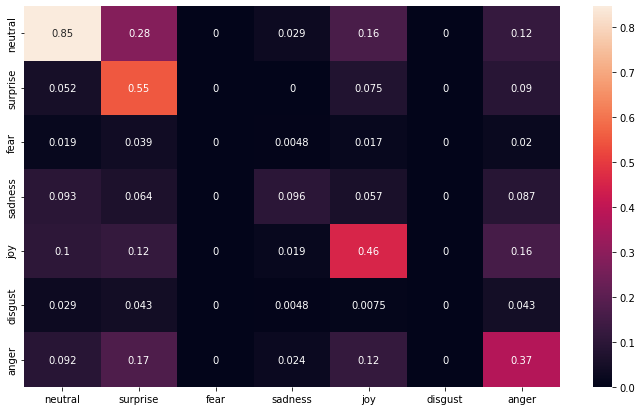

In [ ]:
multimodal_model_out, multimodal_train_losses, multimodal_train_accs, multimodal_val_losses, multimodal_val_accs = train_model(multimodal_model, classes, train_multimodal_dataloader, val_multimodal_dataloader, test_multimodal_dataloader)

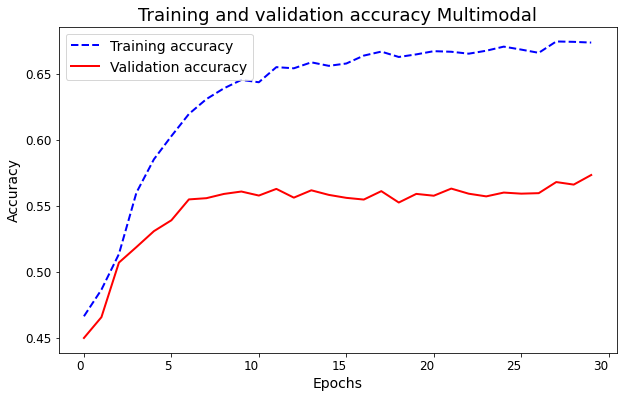

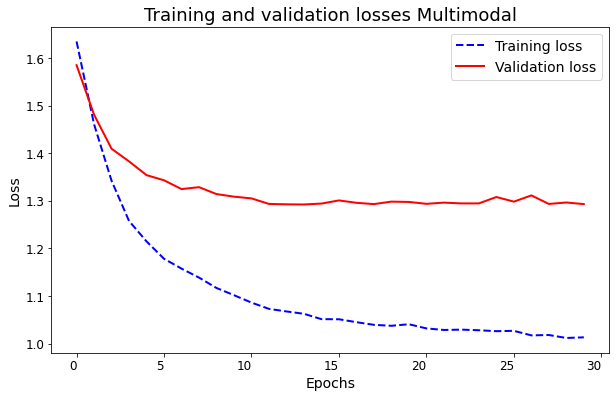

In [ ]:
epochs = range(len( multimodal_train_accs))
Show2Trends2D(epochs,  multimodal_train_accs, 'Training accuracy', epochs, multimodal_val_accs, 'Validation accuracy', 'Training and validation accuracy Multimodal', 'Epochs', 'Accuracy','acc_multimodal.jpg')
Show2Trends2D(epochs,  multimodal_train_losses, 'Training loss', epochs, multimodal_val_losses, 'Validation loss', 'Training and validation losses Multimodal', 'Epochs', 'Loss', 'loss_multimodal.jpg') 

We see the validation loss reaches values similar to the ones we get without audio. A comparison between text and audio results clearly shows that it is more difficult to recognize emotions from audio, so it makes sense that when fusing audio and text, the improvement is not huge.  

## **Citation**

*Dataset provided by:*

S. Poria, D. Hazarika, N. Majumder, G. Naik, R. Mihalcea,
E. Cambria. MELD: A Multimodal Multi-Party Dataset
for Emotion Recognition in Conversation. (2018)